# Projet 6 :  Améliorez le produit IA de votre start-up
<font color = "grey"><i> Chargement des modules necessaires </i></font>

In [ ]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import spacy

from yellowbrick.text import TSNEVisualizer
from sklearn import decomposition
from sklearn import preprocessing
import plotly.graph_objects as go
import seaborn as sns

import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

from nltk.stem.snowball import FrenchStemmer
import gensim
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from sklearn.manifold import TSNE

from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from PIL import ImageFilter
from numpy import asarray
from matplotlib import offsetbox

import main

nltk.download('stopwords')

>## Sommaire
<h1><a href='#data_gen'>I.1) Présentation générale</a></h1>
    <h2><a href='#data_size'>I.2) Taille du jeu de données</a></h2>
    <h2><a href='#data_def'>I.3) Nom,types des colonnes,effectif</a></h2>
    <h2><a href='#data_missing'>I.4) Heatmap</a></h2>


<h1><a href='#data_rev'>II) Analyse des commentaires des restaurants</a></h1>
    <h2><a href='#data_pre_pro'>II.1) Pré-traitement des données textuelles </a></h2>
        <h3><a href='#data_pre_proc_full'>II.1.1)Traitement du corpus avec différents ratings</a></h3>
        <h3><a href='#data_pre_proc_min'>II.1.2)Traitement du corpus avec des ratings < 3</a></h3>
    <h2><a href='#data_acp'>II.2) Réduction de dimension </a></h2>
        <h3><a href='#data_proc_full'>II.2.1)Traitement du corpus contenant des commentaires avec différents ratings</a></h3>
        <h3><a href='#data_proc_min'>II.2.2)Traitement du corpus contenant des commentaires avec ratings < 3 </a></h3>
    <h2><a href='#data_clean'>II.3) Réduction de dimension </a></h2>
        <h3><a href='#data_proc_full_2'>I.3.1)Corpus contenant des commentaires avec ratings < 3</a></h3>
    <h2><a href='#data_visu'>II.4) Visualisation des données </a></h2>
            <h3><a href='#data_com'>II.4.1) Cas de tous les commentaires </a></h3>
            <h3><a href='#data_low_com'>I.4.2)Cas des commentaires avec faibles ratings</a></h3>
            <h3><a href='#data_com2'>II.4.3) Cas de tous les commentaires </a></h3>
            <h3><a href='#data_low_com2'>I.4.5)Cas des commentaires avec faibles ratings</a></h3>
     <h3><a href='#data_evi'>>I.4.6)Mise en évidence des mots utilisés dans les commentaires d'insatisfaction</a></h3>

<h1><a href='#data_pic'>III) Analyse des photos</a></h1>
    <h2><a href='#data_pre_proc_visu'>II.1)Pré-traitement des données visuelles</a></h2>
    <h2><a href='#data_acp_reduc'>II.2)Réduction de dimension et visualisation </a></h2>
    <h2><a href='#data_size'>II.3)Labellisation automatique des images des restaurants à l'aide de **KMeans**</a></h2>
    <h2><a href='#data_size'>II.4)Labellisation des images par **CNN (Convolutional Neural Network)</a></h2>
<h2><a href='#data_size'>II.3) </a></h2>

<font color = "cyan"><i>  Récupération des données et enregistrement sur fichier csv</i></font>

In [2]:

sns.set()

missing_values = ["na", "n/a", "--", " "]
df_yelp = pd.read_csv("data/P6_01_dataset_yelp.csv",
                      sep=',', na_values=missing_values,
                      low_memory=False)
df_yelp_review = pd.read_csv("data/P6_01_dataset_rating.csv",
                             sep=',', na_values=missing_values,
                             low_memory=False)

In [ ]:
plt.style.use('ggplot')

<a id='data_size'></a>
## I.2) Taille du jeu de données
<font color = "cyan"><i> Apercu des permières lignes et colonnes </i></font>

In [ ]:
df = df_yelp
print("Le jeu de données yelp est composé de", df_yelp.shape[1], "colonnes ou attributs et ", df_yelp.shape[0],
      " lignes", )
print("Le jeu de données yelp review est composé de", df_yelp_review.shape[1], "colonnes ou attributs et ",
      df_yelp_review.shape[0], " lignes", )

<a id='data_size'></a>
## I.2) Entrevue du jeu de données
<font color = "cyan"><i> Apercu des permières lignes du jeu de données </i></font>

In [7]:
df_yelp.head()

id                           name  \
0  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
2  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
3  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
4  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   

                                         text_review  rating  
0  J'y suis allé pour acheter un foie gras cru à ...       5  
1  Une adresse immanquable. \nLe meilleur magret ...       5  
2  Très bon, le prix abordable et le restaurant e...       4  
3  Les plats étaient très bons et suffisamment co...       5  
4  Le vin était bon et à un prix pas déconnant do...       2

In [ ]:
df_yelp_review.head()

<a id='data_def'></a>
## I.3) Types de données et leurs effectif
<font color = "cyan"><i> affichage des type et de leurs effectif</i></font>

In [7]:
unsorted_df = pd.DataFrame({'colonne': df_yelp.dtypes.index,
                            'Types': df_yelp.dtypes.values,
                            'Effectif manquant': df_yelp.isna().sum().values,
                            'Effectif manquant %': ((df_yelp.isna().sum(axis=0) / df.shape[0]) * 100).astype(
                                float).values}).style.set_caption("Valeurs manquantes et leurs types df_yelp ")
unsorted_df

In [8]:
unsorted_df = pd.DataFrame({'colonne': df_yelp_review.dtypes.index,
                            'Types': df_yelp_review.dtypes.values,
                            'Effectif manquant': df_yelp_review.isna().sum().values,
                            'Effectif manquant %': ((df_yelp_review.isna().sum(axis=0) / df.shape[0]) * 100).astype(
                                float).values}).style.set_caption("Valeurs manquantes et leurs types df_yelp_review ")
unsorted_df

In [9]:



pd.DataFrame({'colonne': df_yelp_review.dtypes.value_counts().index,
              'nombre': df_yelp_review.dtypes.value_counts().values}).style.set_caption(
    "nombre de variable de chaque type df_yelp_review")

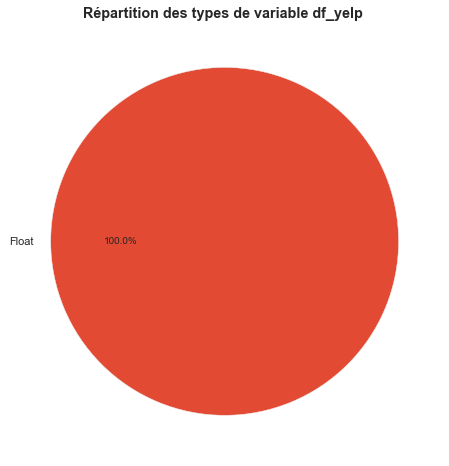

In [10]:
pd.DataFrame({'colonne': df_yelp.dtypes.value_counts().index,
              'nombre': df_yelp.dtypes.value_counts().values}).style.set_caption(
    "nombre de variable de chaque type df_yelp")

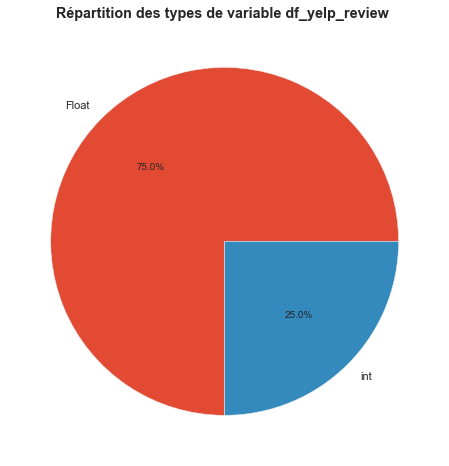

In [11]:
plt.figure(figsize=(8, 8))

df_yelp.dtypes.value_counts().plot.pie(labels=['Float', 'int', 'object'], autopct='%1.1f%%')
plt.ylabel('')
plt.title("Répartition des types de variable df_yelp ", fontweight='bold')
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
df_yelp_review.dtypes.value_counts().plot.pie(labels=['Float', 'int', 'object'], autopct='%1.1f%%')
plt.ylabel('')
plt.title("Répartition des types de variable df_yelp_review ", fontweight='bold')
plt.show()



<a id='data_missing'></a>
## I.4) Effectif manquant

<font color = "cyan"><i> Représentation graphique des valeurs manquantes </i></font>

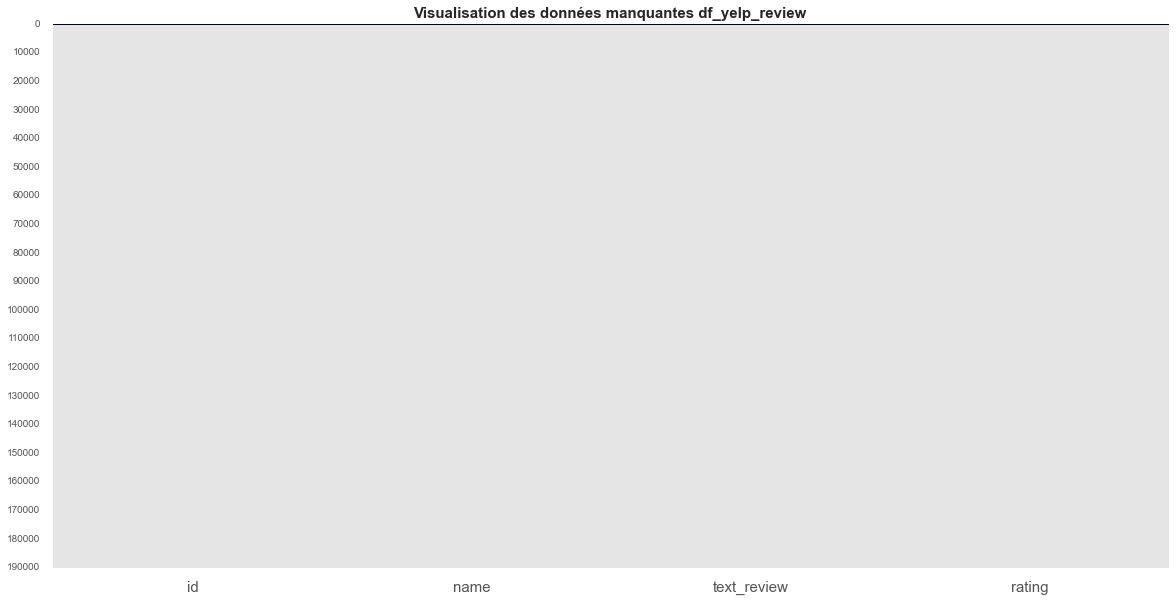

In [13]:
plt.figure(figsize=(20, 10))
plt.title("Visualisation des données manquantes df_yelp  ", fontweight='bold', fontsize=15)
sns.heatmap(df_yelp.isna(), cbar=False)
plt.xticks(fontsize='15')
plt.yticks(np.arange(0, 200000, 10000), np.arange(0, 200000, 10000), fontsize='10')
plt.show()

In [13]:
plt.figure(figsize=(20, 10))
plt.title("Visualisation des données manquantes df_yelp_review ", fontweight='bold', fontsize=15)
sns.heatmap(df_yelp_review.isna(), cbar=False)
plt.xticks(fontsize='15')
plt.yticks(np.arange(0, 200000, 10000), np.arange(0, 200000, 10000), fontsize='10')
plt.show()

<a id='data_rev'></a>
# II) Analyse des commentaires des restaurants

><font color = "cyan"><i>  Mise en place de deux dataframe a partir de df_yelp_review  selon les critères de rating des commentaires (avis positifs >= 3, avis négatif < 3)</i></font>


In [15]:
df_yelp_review_pos = df_yelp_review.query('rating >= 3')
df_yelp_review_neg = df_yelp_review.query('rating < 3')

id                           name  \
0  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
2  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
3  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
5  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
6  WHHt_Jb8Tgidn9mW7oDnIg                 La Coïncidence   

                                         text_review  rating  
0  Une adresse immanquable. \nLe meilleur magret ...       5  
2  Très bon, le prix abordable et le restaurant e...       4  
3  Les plats étaient très bons et suffisamment co...       5  
5  Super resto juste au bord de la Seine avec Not...       5  
6  Top.   Petit coin agréable.   Serveur sympa, e...       5

In [16]:
df_yelp_review_pos.head()

id                           name  \
1   -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
4   IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
12  KggnM_Z4wOa_JExunaaWHg           Le Temps des Cerises   
41  flf_IHitjG7bohr-VbOvbA                Le Petit Canard   
66  Vc-sEV8jnXpHbFeUvP5tLA       Le Relais de l'Entrecôte   

                                          text_review  rating  
1   Grande déception pour un restaurant de bonne r...       1  
4   Le vin était bon et à un prix pas déconnant do...       2  
12  Un gros "Mouais"\nAttiré par les bons commenta...       2  
41  Le repas était convenable mais le rapport qual...       2  
66  J'avais tellement hâte de l'essayer après avoi...       2

In [ ]:
df_yelp_review_neg.head()

<font color = "grey"><i> Analyse des différent sujets dans les commentaires et mise en evidence des sujets d'insatisfaction </i></front>

<a id='#data_pre_pro'></a>
## II.1 Pré-traitement des données textuelles

<font color = "grey"><i>  Les mots des textes sont nettoyés avec la conversion des majuscules en minuscules, la suppression de la ponctuation et des caractères spéciaux, la suppression des **stopwords**. Des transformations telles que la **tokenisation, le stemming et la lemmatisation** vont être appliquées.

<a id='#data_pre_proc_full'></a>
### II.1.1) Traitement du corpus avec différents ratings


<font color = "grey"><i> Chargement et suppression des espaces dans les commentaires :</i></front>

In [ ]:
reviews_pos = []
reviews_neg = []
reviews = []
reviews_df = []
rating = []

for i in df_yelp_review.index:
    reviews.append(df_yelp_review["text_review"][i].strip())
    rating.append(df_yelp_review["rating"][i])

for i in df_yelp_review_pos.index:
    reviews_pos.append(df_yelp_review_pos["text_review"][i].strip())

for i in df_yelp_review_neg.index:
    reviews_neg.append(df_yelp_review_neg["text_review"][i].strip())

for i in df_yelp_review.index:
    reviews_df.append(df_yelp_review["text_review"][i].strip())

<font color = "grey"><i> Nettoyage des textes avec conversion en minuscules et suppression des nombres : </i></font>

In [ ]:
reviews_clean = main.get_clean_data(reviews)
reviews_clean_pos = main.get_clean_data(reviews_pos)
reviews_clean_neg = main.get_clean_data(reviews_neg)
reviews_clean_df = main.get_clean_data(reviews_df)


<font color = "green"><i> Tokenisation afin de montrer le nombre de mots uniques des commentaires de différents restaurants et visualisation </i></font>

In [ ]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
nb_mots_review = []

for elt in reviews_clean_df:
    nb_mots_review.append(len(tokenizer.tokenize(elt)))

df_yelp['nb_words'] = nb_mots_review[0:180]
df_yelp.sort_values(by='nb_words', ascending=False,
                    inplace=True)
df_yelp.head()


In [20]:
plt.figure(figsize=(15, 10))
name = df_yelp["name"].values.tolist()
nb_words = df_yelp["nb_words"].values.tolist()
nb_words_1 = []
name_1 = []

for i, elt in enumerate(nb_words):
    if i < 10:
        nb_words_1.append(elt)
        name_1.append(name[i])

plt.plot(name_1, nb_words_1, color='black',
         linestyle='solid', linewidth=2,
         markerfacecolor='red', markersize=10,
         marker='o')
plt.title('Top 10 des restaurants par nombre de mots des commentaires',
          fontsize=18)
plt.ylabel('Nombres de mots uniques', fontsize=16)
plt.xlabel('Restaurants de Paris', fontsize=16)

plt.text(name_1[0], round(nb_words_1[0], 2) + 0.2,
         str(round(nb_words_1[0], 2)), fontsize=10)
plt.text(name_1[1], round(nb_words_1[1], 2) + 0.2,
         str(round(nb_words_1[1], 2)), fontsize=10)
plt.text(name_1[2], round(nb_words_1[2], 2) + 0.2,
         str(round(nb_words_1[2], 2)), fontsize=10)
plt.text(name_1[3], round(nb_words_1[3], 2) + 0.2,
         str(round(nb_words_1[3], 2)), fontsize=10)
plt.text(name_1[4], round(nb_words_1[4], 2) + 0.2,
         str(round(nb_words_1[4], 2)), fontsize=10)
plt.text(name_1[5], round(nb_words_1[5], 2) + 0.2,
         str(round(nb_words_1[5], 2)), fontsize=10)
plt.text(name_1[6], round(nb_words_1[6], 2) + 0.2,
         str(round(nb_words_1[3], 2)), fontsize=10)
plt.text(name_1[7], round(nb_words_1[7], 2) + 0.2,
         str(round(nb_words_1[4], 2)), fontsize=10)
plt.text(name_1[8], round(nb_words_1[8], 2) + 0.2,
         str(round(nb_words_1[4], 2)), fontsize=10)
plt.text(name_1[9], round(nb_words_1[9], 2) + 0.2,
         str(round(nb_words_1[4], 2)), fontsize=10)


In [ ]:
fig = go.Figure(data=[go.Bar(x=name_1, y=nb_words_1, text=nb_words_1)])
fig.update_layout(title="Top 10 des restaurants par nombre de mots des commentaires")
fig.update_traces(marker_color='rgb(158,202,225)',
                  texttemplate='%{text:.2s}',
                  textposition='outside',
                  base='white',
                  marker_line_width=1.0, opacity=0.5)
fig.update_xaxes(categoryorder="total descending", title_text="Restaurants de Paris")
fig.update_yaxes(title_text="Nombres de mots uniques")
fig.show()


<font color = "grey"><i>Affichage du **Bag of words** </i></font>

<font color = "grey"><i>La représentation par sac de mots est une description de document très utilisée en recherche d'information</i></font>



> <font color = "green"><i>On peut représenter le corpus en bag-of-words (param: **n-grams avec n=1**).
Avec **binary=False**, compte du nombre d'apparition de chaque dans le corpus.
Vectorisation afin de convertir les commentaires en vecteur numérique. Obtiention d'une matrice dont chaque colonne correspond à un mot du corpus et son nombre d'apparition.
</i></font>


In [22]:
cv = CountVectorizer(binary=False)
cv.fit(reviews_clean)
X = cv.transform(reviews_clean)

data_df_words = pd.DataFrame(columns=cv.get_feature_names(),
                             data=X.toarray())
data_df_words


 <font color = "green"><i>Comptage du **Top 20** des mots le plus utilisés </i></font>


In [23]:
counted_words = np.array(np.sum(X, axis=0)).reshape((-1,))
words = np.array(cv.get_feature_names())
words_df = pd.DataFrame({"word": words, "count": counted_words})
words_df.sort_values(by="count", ascending=False).head(20)


id               name  \
14   flf_IHitjG7bohr-VbOvbA    Le Petit Canard   
13   28m3vU-aLX76lMEyT3WL5Q  Pain Vin Fromages   
22   PHsKPp496sFZm9K9Xz_TlA           Sanukiya   
20   PGH7BfXz0PNHuwlSt453rA       Le Boui Boui   
175  g2zDeOraI0CCL6-AvcCxCQ   Le Petit Vendôme   

                                           text_review  \
14    Le repas était convenable mais le rapport qua...   
13    Un resto de raclette dans une rue qui ne paie...   
22    Pour moi le meilleur restaurant japonais à un...   
20    En résumé : ne pas se gaver de pain en attend...   
175   Bon sandwich au bar. \n6€40 le sandwich avec ...   

                                               photo_1  \
14   https://s3-media4.fl.yelpcdn.com/bphoto/GZomUi...   
13   https://s3-media2.fl.yelpcdn.com/bphoto/qh-rZG...   
22   https://s3-media1.fl.yelpcdn.com/bphoto/1NCC7P...   
20   https://s3-media3.fl.yelpcdn.com/bphoto/ByEGEZ...   
175  https://s3-media2.fl.yelpcdn.com/bphoto/u8tUcB...   

                                               photo_2  \
14   https://s3-media2.fl.yelpcdn.com/bphoto/V8MbTz...   
13   https://s3-media1.fl.yelpcdn.com/bphoto/6dZMDZ...   
22   https://s3-media4.fl.yelpcdn.com/bphoto/x0aPCz...   
20   https://s3-media4.fl.yelpcdn.com/bphoto/rlnc6H...   
175  https://s3-media1.fl.yelpcdn.com/bphoto/RVk-eL...   

                                               photo_3  nb_words  
14   https://s3-media2.fl.yelpcdn.com/bphoto/pw9BO8...        25  
13   https://s3-media3.fl.yelpcdn.com/bphoto/hUE6J4...        24  
22   https://s3-media2.fl.yelpcdn.com/bphoto/va06K7...        23  
20   https://s3-media1.fl.yelpcdn.com/bphoto/rGuWld...        23  
175  https://s3-media3.fl.yelpcdn.com/bphoto/Tj6XbF...        20

 <font color = "green"><i>Utilisation de **bi-grams** pour de capturer d'avantage les sentiments : </i></font>


In [25]:
trigram_vectorizer = CountVectorizer(binary=False, ngram_range=(1, 2))
trigram_vectorizer.fit(reviews_clean)
X3 = trigram_vectorizer.transform(reviews_clean)
data_df_trigram = pd.DataFrame(columns=trigram_vectorizer.get_feature_names(),
                               data=X3.toarray())
data_df_trigram

<font color = "grey"><i> Comptage du **Top 20** des trigrammes le plus utilisés :</i></front>


**TF-IDF :term frequency-inverse document frequency**

 <font color = "grey"><i>Le TF-IDF est une méthode de pondération souvent utilisée en recherche d'information et en particulier
dans la fouille de textes. Cette mesure statistique permet d'évaluer l'importance d'un terme contenu
dans un document, relativement à une collection ou un corpus.</i></font>


> <font color = "green"><i>On affecte un poids à chaque mot en fonction de leur fréquence d'apparition relativement dans tous les commentaires.
</i></font>

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectorizer.fit(reviews_clean)
X = tfidf_vectorizer.transform(reviews_clean)
data_df_tfidf = pd.DataFrame(columns=tfidf_vectorizer.get_feature_names(),
                             data=X.toarray())
data_df_tfidf

<font color = "grey"><i>Comptage du **Top 10** des mots le plus utilisés :
</i></font>

In [ ]:
tf_counted_words = np.array(np.sum(X, axis=0)).reshape((-1,))
tf_words = np.array(tfidf_vectorizer.get_feature_names())

tf_words_df = pd.DataFrame({"word": tf_words, "count": tf_counted_words})
tf_words_df.sort_values(by="count", ascending=False).head(10)

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



abim  abim heureux  abord  abord ailleur  abord bistro  abord chef  \
0       0             0      0              0             0           0   
1       0             0      0              0             0           0   
2       0             0      1              0             0           0   
3       0             0      0              0             0           0   
4       0             0      0              0             0           0   
..    ...           ...    ...            ...           ...         ...   
496     0             0      0              0             0           0   
497     0             0      0              0             0           0   
498     0             0      0              0             0           0   
499     0             0      0              0             0           0   
500     0             0      0              0             0           0   

     abord final  abord goût  abord menu  abord mid  ...  être sup  île  \
0              0           0           0          0  ...         0    0   
1              0           0           0          0  ...         0    0   
2              0           0           0          0  ...         0    0   
3              0           0           0          0  ...         0    0   
4              0           0           0          0  ...         0    0   
..           ...         ...         ...        ...  ...       ...  ...   
496            0           0           0          0  ...         0    0   
497            0           0           0          0  ...         0    0   
498            0           0           0          0  ...         0    0   
499            0           0           0          0  ...         0    0   
500            0           0           0          0  ...         0    0   

     île saint  îlot  œil  œil surtout  œuf  œuf mayonnai  œuvr  œuvr respect  
0            0     0    0            0    0             0     0             0  
1            0     0    0            0    0             0     0             0  
2            0     0    0            0    0             0     0             0  
3            0     0    0            0    0             0     0             0  
4            0     0    0            0    0             0     0             0  
..         ...   ...  ...          ...  ...           ...   ...           ...  
496          0     0    0            0    0             0     0             0  
497          0     0    0            0    0             0     0             0  
498          0     0    0            0    0             0     0             0  
499          0     0    0            0    0             0     0             0  
500          0     0    0            0    0             0     0             0  

[501 rows x 7837 columns]

<font color = "green"><i>**TF-IDF** avec seuil de fréquence et normalisation :
</i></font>


> <font color = "grey"><i>On affecte un poids à chaque mot en fonction de leur fréquence d'apparition relativement dans tous les commentaires. Le paramètre **max_df (et min_df)** définit le seuil de fréquence au-dessus (en-dessous pour min_df) duquel les mots du corpus ne sont pas pris en compte.


In [ ]:
tf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                binary=True)
tf_vectorizer.fit(reviews_clean)
X = tf_vectorizer.transform(reviews_clean)
data_df_tf = pd.DataFrame(columns=tf_vectorizer.get_feature_names(),
                          data=X.toarray())
data_df_tf


<font color = "grey"><i> Comptage du **Top 10** des mots le plus utilisés :
</i></font>


In [ ]:
tf_counted_words = np.array(np.sum(X, axis=0)).reshape((-1,))
tf_words = np.array(tf_vectorizer.get_feature_names())
tf_words_df = pd.DataFrame({"word": tf_words, "count": tf_counted_words})
tf_words_df.sort_values(by="count", ascending=False).head(10)


<font color = "grey"><i> Modification du seuil de fréquence **min_df=5** :
</i></font>


In [30]:
tf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                binary=True)
tf_vectorizer.fit(reviews_clean)
X = tf_vectorizer.transform(reviews_clean)

data_df_tf = pd.DataFrame(columns=tf_vectorizer.get_feature_names(),
                          data=X.toarray())
data_df_tf


<font color = "grey"><i> Comptage du **Top 10** des mots le plus utilisés :
</i></font>


In [31]:
tf_counted_words = np.array(np.sum(X, axis=0)).reshape((-1,))
tf_words = np.array(tf_vectorizer.get_feature_names())

tf_words_df = pd.DataFrame({"word": tf_words, "count": tf_counted_words})
tf_words_df.sort_values(by="count", ascending=False).head(10)


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



abord  abrit  absolu  accent  acceuill  accompagn  accompagn augment  \
0    0.000000    0.0     0.0     0.0       0.0        0.0                0.0   
1    0.000000    0.0     0.0     0.0       0.0        0.0                0.0   
2    0.292005    0.0     0.0     0.0       0.0        0.0                0.0   
3    0.000000    0.0     0.0     0.0       0.0        0.0                0.0   
4    0.000000    0.0     0.0     0.0       0.0        0.0                0.0   
..        ...    ...     ...     ...       ...        ...                ...   
496  0.000000    0.0     0.0     0.0       0.0        0.0                0.0   
497  0.000000    0.0     0.0     0.0       0.0        0.0                0.0   
498  0.000000    0.0     0.0     0.0       0.0        0.0                0.0   
499  0.000000    0.0     0.0     0.0       0.0        0.0                0.0   
500  0.000000    0.0     0.0     0.0       0.0        0.0                0.0   

      accueil  accueil bien  accueil bon  ...  étag  étoil  étoil pens  \
0    0.000000           0.0          0.0  ...   0.0    0.0         0.0   
1    0.000000           0.0          0.0  ...   0.0    0.0         0.0   
2    0.000000           0.0          0.0  ...   0.0    0.0         0.0   
3    0.000000           0.0          0.0  ...   0.0    0.0         0.0   
4    0.000000           0.0          0.0  ...   0.0    0.0         0.0   
..        ...           ...          ...  ...   ...    ...         ...   
496  0.000000           0.0          0.0  ...   0.0    0.0         0.0   
497  0.155405           0.0          0.0  ...   0.0    0.0         0.0   
498  0.000000           0.0          0.0  ...   0.0    0.0         0.0   
499  0.000000           0.0          0.0  ...   0.0    0.0         0.0   
500  0.000000           0.0          0.0  ...   0.0    0.0         0.0   

     étranger  évident  évit  être  être décevoir  être peu  île  
0         0.0      0.0   0.0   0.0            0.0       0.0  0.0  
1         0.0      0.0   0.0   0.0            0.0       0.0  0.0  
2         0.0      0.0   0.0   0.0            0.0       0.0  0.0  
3         0.0      0.0   0.0   0.0            0.0       0.0  0.0  
4         0.0      0.0   0.0   0.0            0.0       0.0  0.0  
..        ...      ...   ...   ...            ...       ...  ...  
496       0.0      0.0   0.0   0.0            0.0       0.0  0.0  
497       0.0      0.0   0.0   0.0            0.0       0.0  0.0  
498       0.0      0.0   0.0   0.0            0.0       0.0  0.0  
499       0.0      0.0   0.0   0.0            0.0       0.0  0.0  
500       0.0      0.0   0.0   0.0            0.0       0.0  0.0  

[501 rows x 1292 columns]

<font color = "grey"><i> Comptage du **Top 10** des mots le moins utilisés :
</i></font>


In [32]:
tf_counted_words = np.array(np.sum(X, axis=0)).reshape((-1,))
tf_words = np.array(tf_vectorizer.get_feature_names())

tf_words_df = pd.DataFrame({"word": tf_words, "count": tf_counted_words})
tf_words_df.sort_values(by="count", ascending=True).head(10)


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



word      count
171       bon  16.930288
983   restaur  15.089089
117     avoir  14.250535
849      plat  11.976443
1068   servic  10.975996
7     accueil  10.350218
150      bien   9.584912
817       pet   8.631567
50    ambianc   8.559677
830       peu   8.348039

<a id='#data_pre_proc_min'></a>
### II.1.2) Traitement du corpus avec des ratings < 3

In [33]:
tf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                binary=True)
tf_vectorizer.fit(reviews_clean_neg)
X = tf_vectorizer.transform(reviews_clean_neg)

data_df_tf = pd.DataFrame(columns=tf_vectorizer.get_feature_names(),
                          data=X.toarray())
data_df_tf


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



abord  absolu  accompagn   accueil  accueil sympath     ador  \
0    0.000000     0.0        0.0  0.000000              0.0  0.00000   
1    0.000000     0.0        0.0  0.000000              0.0  0.00000   
2    0.423446     0.0        0.0  0.000000              0.0  0.00000   
3    0.000000     0.0        0.0  0.000000              0.0  0.00000   
4    0.000000     0.0        0.0  0.000000              0.0  0.00000   
..        ...     ...        ...       ...              ...      ...   
496  0.000000     0.0        0.0  0.000000              0.0  0.00000   
497  0.000000     0.0        0.0  0.259235              0.0  0.00000   
498  0.000000     0.0        0.0  0.000000              0.0  0.00000   
499  0.000000     0.0        0.0  0.000000              0.0  0.00000   
500  0.000000     0.0        0.0  0.000000              0.0  0.44737   

        adres    adress   agréabl       aim  ...  visit  voilà  voir  \
0    0.259263  0.000000  0.236914  0.000000  ...    0.0    0.0   0.0   
1    0.000000  0.000000  0.000000  0.000000  ...    0.0    0.0   0.0   
2    0.000000  0.000000  0.000000  0.000000  ...    0.0    0.0   0.0   
3    0.000000  0.000000  0.272507  0.000000  ...    0.0    0.0   0.0   
4    0.000000  0.000000  0.000000  0.000000  ...    0.0    0.0   0.0   
..        ...       ...       ...       ...  ...    ...    ...   ...   
496  0.000000  0.000000  0.000000  0.000000  ...    0.0    0.0   0.0   
497  0.000000  0.000000  0.000000  0.000000  ...    0.0    0.0   0.0   
498  0.000000  0.374558  0.000000  0.311526  ...    0.0    0.0   0.0   
499  0.000000  0.000000  0.000000  0.000000  ...    0.0    0.0   0.0   
500  0.000000  0.000000  0.000000  0.000000  ...    0.0    0.0   0.0   

         vrai  yelp   ça  élev  équip  étoil  être  
0    0.000000   0.0  0.0   0.0    0.0    0.0   0.0  
1    0.000000   0.0  0.0   0.0    0.0    0.0   0.0  
2    0.000000   0.0  0.0   0.0    0.0    0.0   0.0  
3    0.272507   0.0  0.0   0.0    0.0    0.0   0.0  
4    0.307407   0.0  0.0   0.0    0.0    0.0   0.0  
..        ...   ...  ...   ...    ...    ...   ...  
496  0.000000   0.0  0.0   0.0    0.0    0.0   0.0  
497  0.000000   0.0  0.0   0.0    0.0    0.0   0.0  
498  0.000000   0.0  0.0   0.0    0.0    0.0   0.0  
499  0.000000   0.0  0.0   0.0    0.0    0.0   0.0  
500  0.000000   0.0  0.0   0.0    0.0    0.0   0.0  

[501 rows x 364 columns]

<font color = "grey"><i> Comptage du **Top 10** des mots le plus utilisés :
</i></font>


In [34]:
tf_counted_words = np.array(np.sum(X, axis=0)).reshape((-1,))
tf_words = np.array(tf_vectorizer.get_feature_names())

tf_words_df = pd.DataFrame({"word": tf_words, "count": tf_counted_words})
tf_words_df.sort_values(by="count", ascending=False).head(10)

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



word      count
49       bon  23.526844
279  restaur  21.712066
35     avoir  20.637452
234     plat  16.342926
302   servic  15.262261
3    accueil  14.331546
42      bien  13.150722
12   ambianc  11.857804
216     pari  11.761855
226      pet  11.486974

<font color = "grey"><i>
</i></font>


In [35]:
tf_counted_words = np.array(np.sum(X, axis=0)).reshape((-1,))
tf_words = np.array(tf_vectorizer.get_feature_names())

tf_words_df = pd.DataFrame({"word": tf_words, "count": tf_counted_words})
tf_words_df.sort_values(by="count", ascending=True).head(10)

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



word     count
304        servir  1.711671
50    bon rapport  1.725131
47           boir  1.744978
48      boir verr  1.744978
147      foi gras  1.749190
164         group  1.757696
133     entre ami  1.759904
258        puisqu  1.777267
170           hyp  1.802779
251  prix correct  1.802902

<a ID='#data_acp'>
## II.2) Réduction de dimension ACP</a>


In [36]:
# Transformation de la colonne text_review en liste de listes
def read_review(row, column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))


documents = []

for index, row in df_yelp_review.iterrows():
    documents.append(read_review(row, "text_review"))

# Création du modèle Word2Vec
model = gensim.models.Word2Vec(vector_size=100, window=5,
                               min_count=1, sg=0, workers=4)
model.build_vocab(documents)

# Entrainement du modèle Word2Vec
model.train(documents,
            total_examples=len(documents),
            epochs=model.epochs)


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



abord  absolu  accompagn   accueil  accueil sympath      ador  \
0    0.000000     0.0        0.0  0.000000              0.0  0.000000   
1    0.416474     0.0        0.0  0.000000              0.0  0.000000   
2    0.000000     0.0        0.0  0.000000              0.0  0.000000   
3    0.000000     0.0        0.0  0.000000              0.0  0.000000   
4    0.000000     0.0        0.0  0.000000              0.0  0.000000   
..        ...     ...        ...       ...              ...       ...   
449  0.000000     0.0        0.0  0.000000              0.0  0.000000   
450  0.000000     0.0        0.0  0.256914              0.0  0.000000   
451  0.000000     0.0        0.0  0.000000              0.0  0.000000   
452  0.000000     0.0        0.0  0.000000              0.0  0.000000   
453  0.000000     0.0        0.0  0.000000              0.0  0.443228   

        adres    adress   agréabl      aim  ...  visit  voilà  voir      vrai  \
0    0.257689  0.000000  0.234921  0.00000  ...    0.0    0.0   0.0  0.000000   
1    0.000000  0.000000  0.000000  0.00000  ...    0.0    0.0   0.0  0.000000   
2    0.000000  0.000000  0.267945  0.00000  ...    0.0    0.0   0.0  0.274832   
3    0.000000  0.000000  0.000000  0.00000  ...    0.0    0.0   0.0  0.000000   
4    0.000000  0.000000  0.279241  0.00000  ...    0.0    0.0   0.0  0.000000   
..        ...       ...       ...      ...  ...    ...    ...   ...       ...   
449  0.000000  0.000000  0.000000  0.00000  ...    0.0    0.0   0.0  0.000000   
450  0.000000  0.000000  0.000000  0.00000  ...    0.0    0.0   0.0  0.000000   
451  0.000000  0.398868  0.000000  0.33047  ...    0.0    0.0   0.0  0.000000   
452  0.000000  0.000000  0.000000  0.00000  ...    0.0    0.0   0.0  0.000000   
453  0.000000  0.000000  0.000000  0.00000  ...    0.0    0.0   0.0  0.000000   

     yelp   ça  élev  équip  étoil  être  
0     0.0  0.0   0.0    0.0    0.0   0.0  
1     0.0  0.0   0.0    0.0    0.0   0.0  
2     0.0  0.0   0.0    0.0    0.0   0.0  
3     0.0  0.0   0.0    0.0    0.0   0.0  
4     0.0  0.0   0.0    0.0    0.0   0.0  
..    ...  ...   ...    ...    ...   ...  
449   0.0  0.0   0.0    0.0    0.0   0.0  
450   0.0  0.0   0.0    0.0    0.0   0.0  
451   0.0  0.0   0.0    0.0    0.0   0.0  
452   0.0  0.0   0.0    0.0    0.0   0.0  
453   0.0  0.0   0.0    0.0    0.0   0.0  

[454 rows x 331 columns]

<font color = "grey"><i>Récupération du vocabulaire appris :
</i></font>

 <a id='#data_proc_full'></a>
 ### I.3.1) Traitement du corpus avec différents ratings

In [37]:
word_vectors = model.wv
count = 0

for word in word_vectors.key_to_index:
    if count < 20:
        print(word)
        count += 1
    else:
        break


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



word      count
43       bon  22.467396
252  restaur  20.089027
31     avoir  19.425367
209     plat  14.617040
273   servic  14.107121
3    accueil  13.481156
38      bien  12.155319
12   ambianc  11.588686
191     pari  11.547915
205      peu  11.176890

<font color = "grey"><i>Visualisation de la sémantique du corpus avec Word2Vec :

</i></font>

In [38]:
wanted_words = []
count = 0

for word in word_vectors.key_to_index:
    if count < 65:
        wanted_words.append(word)
        count += 1
    else:
        break

wanted_vocab = dict((k, word_vectors.key_to_index[k])
                    for k in wanted_words if k in word_vectors.key_to_index)
print(wanted_vocab)
print(model.wv[wanted_vocab])
X = model.wv[wanted_vocab]
tsne_model = TSNE(perplexity=20, n_components=2, init="pca",
                  n_iter=5000, random_state=23)

Y = tsne_model.fit_transform(X)

fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('#9a9c9c')
ax.scatter(Y[:, 0], Y[:, 1], color='r')
words = list(wanted_vocab)

for i, word in enumerate(words):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]), size=15)

ax.set_yticklabels([])
ax.set_xticklabels([])
fig.suptitle("Similarité des mots des commentaires par Word2Vec", fontsize=20)
plt.show()



c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



word     count
275           servir  1.716809
129         foi gras  1.762397
226     prix correct  1.800199
13   ambianc chaleur  1.806618
231           puisqu  1.810503
118        entre ami  1.815889
308              tre  1.830380
162             jour  1.839435
220              pre  1.841467
151              hyp  1.842464

<font color = "RED"><i>ANALYSE
</i></font>


> <font color='green'> Des groupes de mots se forment le long d'une droite, un groupe contenant des mots  **unique, super, sympatique, top** qui caractérisent les commentaires positifs.</font>

<a id='data_proc_min'></a>

### II.2.2) Traitement du corpus contenant des commentaires avec ratings < 3

In [ ]:
documents = []

for index, row in df_yelp_review_neg.iterrows():
    documents.append(read_review(row, "text_review"))

# Création du modèle Word2Vec
model = gensim.models.Word2Vec(vector_size=100, window=5,
                               min_count=1, sg=0, workers=4)
model.build_vocab(documents)

# Entrainement du modèle Word2Vec
model.train(documents,
            total_examples=len(documents),
            epochs=model.epochs)
word_vectors = model.wv
count = 0

for word in word_vectors.key_to_index:
    if count < 20:
        print(word)
        count += 1
    else:
        break



<font color = "grey"><i>Visualisation de la sémantique du corpus avec Word2Vec :

</i></font>

In [ ]:
wanted_words = []
count = 0

for word in word_vectors.key_to_index:
    if count < 100:
        wanted_words.append(word)
        count += 1
    else:
        break

wanted_vocab = dict((k, word_vectors.key_to_index[k])
                    for k in wanted_words if k in word_vectors.key_to_index)

X = model.wv[wanted_vocab]
tsne_model = TSNE(perplexity=20, n_components=2, init="pca",
                  n_iter=5000, random_state=23)

Y = tsne_model.fit_transform(X)

fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('#9a9c9c')
ax.scatter(Y[:, 0], Y[:, 1], color='r')
words = list(wanted_vocab)

for i, word in enumerate(words):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]),
                 size=15)

ax.set_yticklabels([])
ax.set_xticklabels([])
fig.suptitle("Similarité des mots des commentaires négatifs par Word2Vec", fontsize=20)
plt.show()


> <font color='red'>ANALYSE</font>

> <font color='red'> Pour les commentaires avec un mauvais rating, les groupes de mots sont plus dispersés. Certains mots se rapprochent tels que **qualité, prix, faible, rapport** qui caractérisent les commentaires négatifs. Parmi ces commentaires, on voit bien qu'il y a un mélange de mots à connotation positive et négative.</font>

<font color = "grey"><i>Visualisation t-SNE du corpus:
</i></font>


### Traitement du corpus contenant des commentaires avec différents ratings

In [ ]:


tfidf = TfidfVectorizer(min_df=2, binary=True)

X = tfidf.fit_transform(reviews_clean)

tsne = TSNEVisualizer()
tsne.fit(X)
tsne.show()

### Traitement du corpus contenant des commentaires avec ratings < 3

In [ ]:
from sklearn import manifold
from yellowbrick.text import TSNEVisualizer

tfidf = TfidfVectorizer(min_df=2, binary=True)

X = tfidf.fit_transform(reviews_clean_neg)

tsne = TSNEVisualizer()
tsne.fit(X)
tsne.show()

<a id='data_clean'></a>
## II.3) Réduction de dimension

In [ ]:
vec = TfidfVectorizer(min_df=2,
                      binary=True)
vec.fit(reviews_clean)
X = vec.transform(reviews_clean)
features = vec.get_feature_names()

wanted_words = []
count = 0
for word in word_vectors.key_to_index:
    if count < 80:
        wanted_words.append(word)
        count += 1
    else:
        break

wanted_vocab = dict((k, word_vectors.key_to_index[k])
                    for k in wanted_words if k in word_vectors.key_to_index)

X = model.wv[wanted_vocab]
pca = decomposition.PCA(n_components=3).fit(X)

Y = pca.transform(X)

In [ ]:
def display_vec():
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.patch.set_facecolor('#9a9c9c')
    ax.scatter(Y[:, 0], Y[:, 1], color='r')
    words = list(wanted_vocab)

    for i, word in enumerate(words):
        plt.annotate(word, xy=(Y[i, 0], Y[i, 1]),
                     size=15)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.suptitle("Top {} des mots sur le 1e plan factoriel ACP"
                 .format(count), fontsize=20)
    plt.show()


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



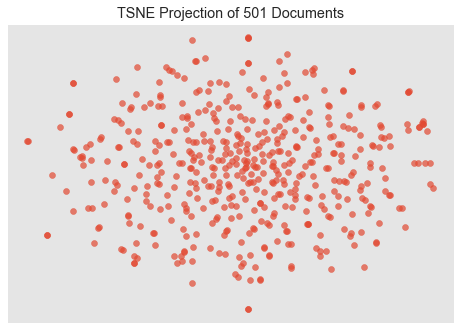

<AxesSubplot:title={'center':'TSNE Projection of 501 Documents'}>

In [44]:
display_vec()


<a id='data_proc_full_2'></a>
### I.3.1) Corpus contenant des commentaires avec ratings < 3

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



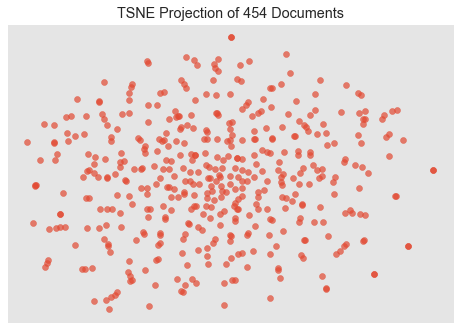

<AxesSubplot:title={'center':'TSNE Projection of 454 Documents'}>

In [45]:
vec = TfidfVectorizer(min_df=2,
                      binary=True)
vec.fit(reviews_clean_neg)
X = vec.transform(reviews_clean_neg)
features = vec.get_feature_names()
wanted_words = []
count = 0

for word in word_vectors.key_to_index:
    if count < 80:
        wanted_words.append(word)
        count += 1
    else:
        break

wanted_vocab = dict((k, word_vectors.key_to_index[k])
                    for k in wanted_words if k in word_vectors.key_to_index)

X = model.wv[wanted_vocab]
pca = decomposition.PCA(n_components=3).fit(X)

Y = pca.transform(X)


def display_vec():
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.patch.set_facecolor('#9a9c9c')
    ax.scatter(Y[:, 0], Y[:, 1], color='r')
    words = list(wanted_vocab)

    for i, word in enumerate(words):
        plt.annotate(word, xy=(Y[i, 0], Y[i, 1]),
                     size=15)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.suptitle("Top {} des mots de commentaires négatifs sur le 1e plan factoriel ACP"
                 .format(count), fontsize=20)
    plt.show()


display_vec()


<a href='data_visu'></a>
## I.5) Visualisation des données
<font color = "grey"><i>Word cloud des commentaires avec différents ratings
</i></font>

<font color = "grey"><i>Fréquence des mots employés dans les commentaires positifs et négatifs
 </i></font>


In [46]:
cloud_all = {'text_all': []}
text = " ".join(i for i in reviews_clean)
cloud_all['text_all'].append(text)

wc_neg = WordCloud(background_color="white", max_words=100,
                   contour_width=0.5,
                   contour_color='red',
                   max_font_size=500)

wc_neg.generate(text)
img_dash = wc_neg.to_file('data/wc_pic.png')

plt.figure(figsize=(15, 10))
plt.imshow(wc_neg, interpolation=None)
plt.title("Mots les plus utilisés dans tous les commentaires", fontsize=20, color='Red')
plt.axis("off")
plt.show()


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [47]:
data_cloud_all = pd.DataFrame(cloud_all)
data_cloud_all.to_csv("data/P6_02_cloud_all.csv", sep=',', index=False)


<font color = "grey"><i>Pour les commentaires avec des ratings < 3.
</i></font>


In [ ]:
cloud_neg = {'text_neg': []}
text = " ".join(i for i in reviews_clean_neg)
cloud_neg['text_neg'].append(text)
wc_neg = WordCloud(background_color="white", max_words=100,
                   contour_width=0.5,
                   contour_color='red',
                   max_font_size=500)
wc_neg.generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wc_neg, interpolation=None)
plt.title("Mots les plus utilisés dans les commentaires de faibles ratings",
          fontsize=20,
          color='Red')
plt.axis("off")
plt.show()


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



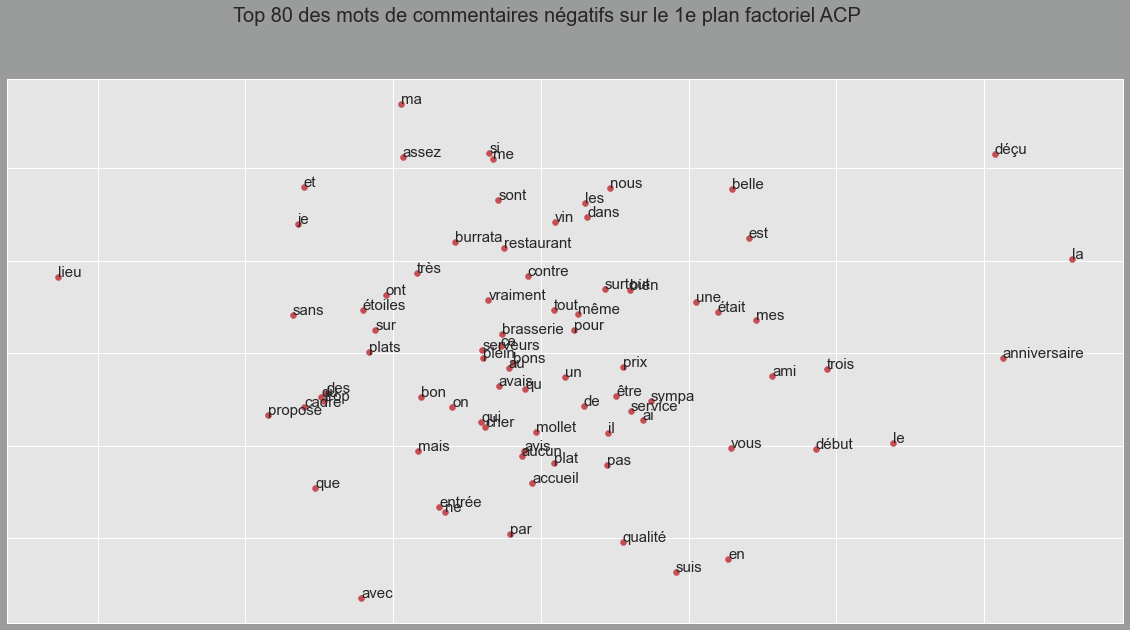

In [49]:
data_cloud_neg = pd.DataFrame(cloud_neg)
data_cloud_neg.to_csv("data/P6_02_cloud_neg.csv", sep=',', index=False)


<font color = "grey"><i> modelling avec LDA (Latente Dirichlet Allocation) et NMF (Negative Matrix Factorisation)

</i></font>


<a id='data_com'></a>
### II.4.1) Cas de tous les commentaires :
<font color = "green"><i>algorithmes qui permet de trouver les distributions latentes par rapport aux variables observées à savoir les distributions de mots sur les différents thèmes, proportions de thèmes pour chaque document, proportions d’apparition d’un thème sur le corpus

> Latente Dirichlet Allocation
</i></font>


In [51]:
tf_vectorizer = CountVectorizer(min_df=2)
tf = tf_vectorizer.fit_transform(reviews_clean)
tf_feature_names = tf_vectorizer.get_feature_names()



In [ ]:
n_topics = 20
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

lda.fit(tf)

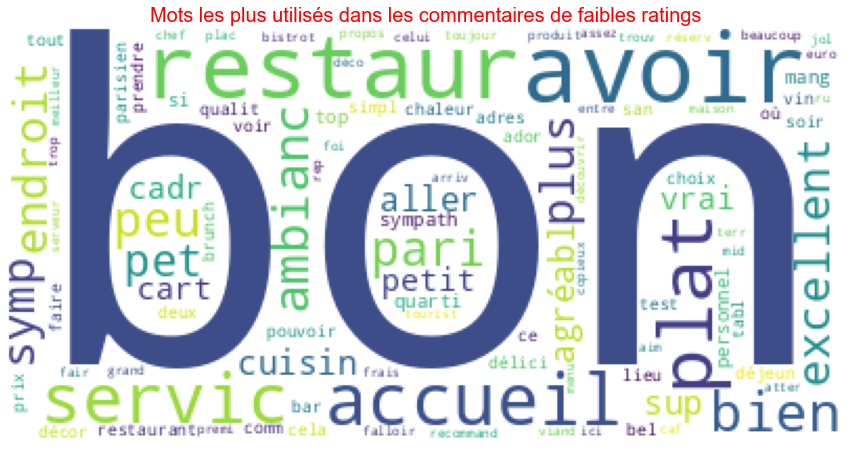

In [52]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Sujet {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [53]:
no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

<font color = "grey"><i>Visualisation de la distribution des mots sur chaque sujet :
</i></front>


In [ ]:
data_all = {'features_all': [], 'weights_all': []}


def plot_top_words(model, feature_names, n_top_words,
                   title, color):
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:n_top_words]):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        for i in top_features_ind:
            data_all['features_all'].append(feature_names[i])
            data_all['weights_all'].append(topic[i])

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=color)
        ax.set_title(f'Sujet n°{topic_idx + 1}', fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)

        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

        fig.suptitle(title, fontsize=25)
        ax.tick_params(bottom=False)
        ax.set(xticklabels=[])

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


no_top_words = 12
plot_top_words(lda, tf_feature_names, no_top_words,
               'Sujets mis en evidence par LDA dans tous les commentaires',
               'g')


In [54]:
data_text_all = pd.DataFrame(data_all)
data_text_all.to_csv("data/P6_02_text_all_LDA.csv", sep=',', index=False)



c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



<a id='data_low_com'></a> </front>
### I.4.2) Cas des commentaires avec faibles ratings :

In [57]:
tf_vectorizer = CountVectorizer(min_df=2)
tf = tf_vectorizer.fit_transform(reviews_clean_neg)
tf_feature_names = tf_vectorizer.get_feature_names()

n_topics = 20

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)
lda.fit(tf)


def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Sujet {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)


<font color = "grey"><i>distribution des mots sur chaque sujet
</i></font>


In [ ]:
data_neg = {'features_neg': [], 'weights_neg': []}


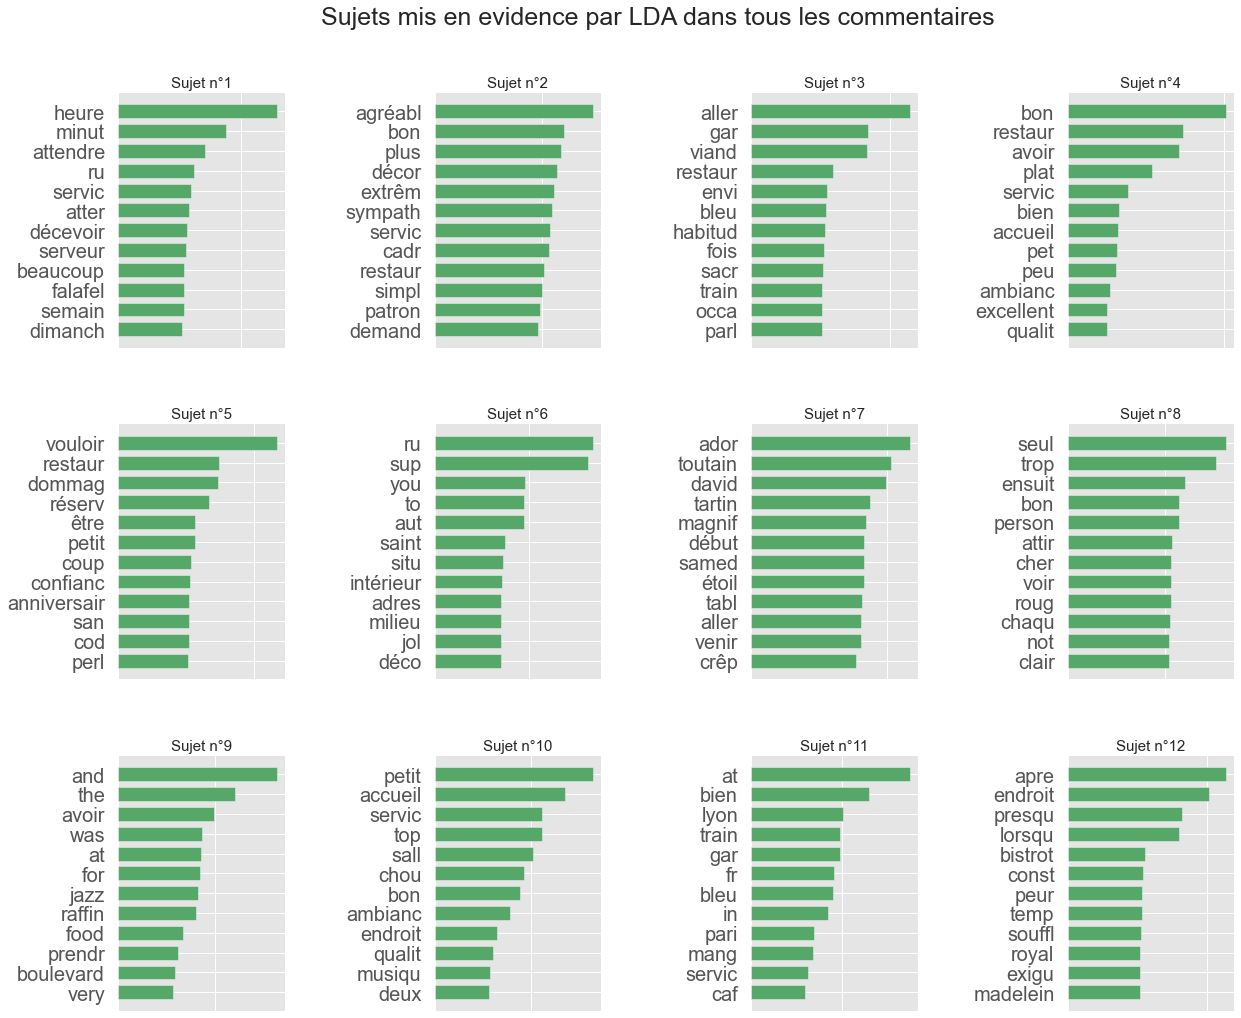

In [59]:
def plot_top_words_neg(model, feature_names, n_top_words,
                       title, color):
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:n_top_words]):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        for i in top_features_ind:
            data_neg['features_neg'].append(feature_names[i])
            data_neg['weights_neg'].append(topic[i])

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,
                color=color)
        ax.set_title(f'Sujet {topic_idx + 1}',
                     fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)
        ax.tick_params(bottom=False)
        ax.set(xticklabels=[])

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [60]:
no_top_words = 12
plot_top_words_neg(lda, tf_feature_names, no_top_words,
                   'Sujets mis en evidence par LDA dans les commentaires de faible rating',
                   'r')


<font color = "grey"><i>chargement de Negative Matrix Factorisation
</i></font>

In [61]:
data_text_neg = pd.DataFrame(data_neg)
data_text_neg.to_csv("data/P6_02_text_neg_LDA.csv", sep=',', index=False)

Sujet 0:
accueil restaur brunch chouet avoir chaleur royal chocolat chaud lieu
Sujet 1:
david toutain gar chef pens fois deux alain étoil occa
Sujet 2:
samed galet crêp propos savoir chocolat breton devantur aim saint
Sujet 3:
truff fois chaqu person chouet italien rep adress apparent vu
Sujet 4:
dîn monsieur meilleur mamm agréabl quelqu nourritur tourist désorm ème
Sujet 5:
quarti restaur tourist bar coup décor sup oper trop bistrot
Sujet 6:
heure presqu temp peur depuis fameux être décevoir test cocott
Sujet 7:
adres ce ru sup situ saint yelp prendr local quarti
Sujet 8:
dauphin puisqu boir chocolat group élev chaud plac plutôt verr
Sujet 9:
bon avoir accueil plat servic peu bien excellent ambianc restaur
Sujet 10:
accueil autr pari personnel toujour délici truff rar sourire faire
Sujet 11:
cuisin march ador visit deux essai réserv réel frer dur
Sujet 12:
gen pet délici institu bar appréci cocktail succe réel dîn
Sujet 13:
top vin to my canard bon sauc this of pur
Sujet 14:
ami aller

<a id='data_com2'>
### II.4.3) Cas de tous les commentaires

In [62]:
tfidf_vectorizer = TfidfVectorizer(min_df=2)
tfidf = tfidf_vectorizer.fit_transform(reviews_clean)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1,
          l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)


<font color = "grey"><i>distribution des mots sur chaque sujet
</i></font>


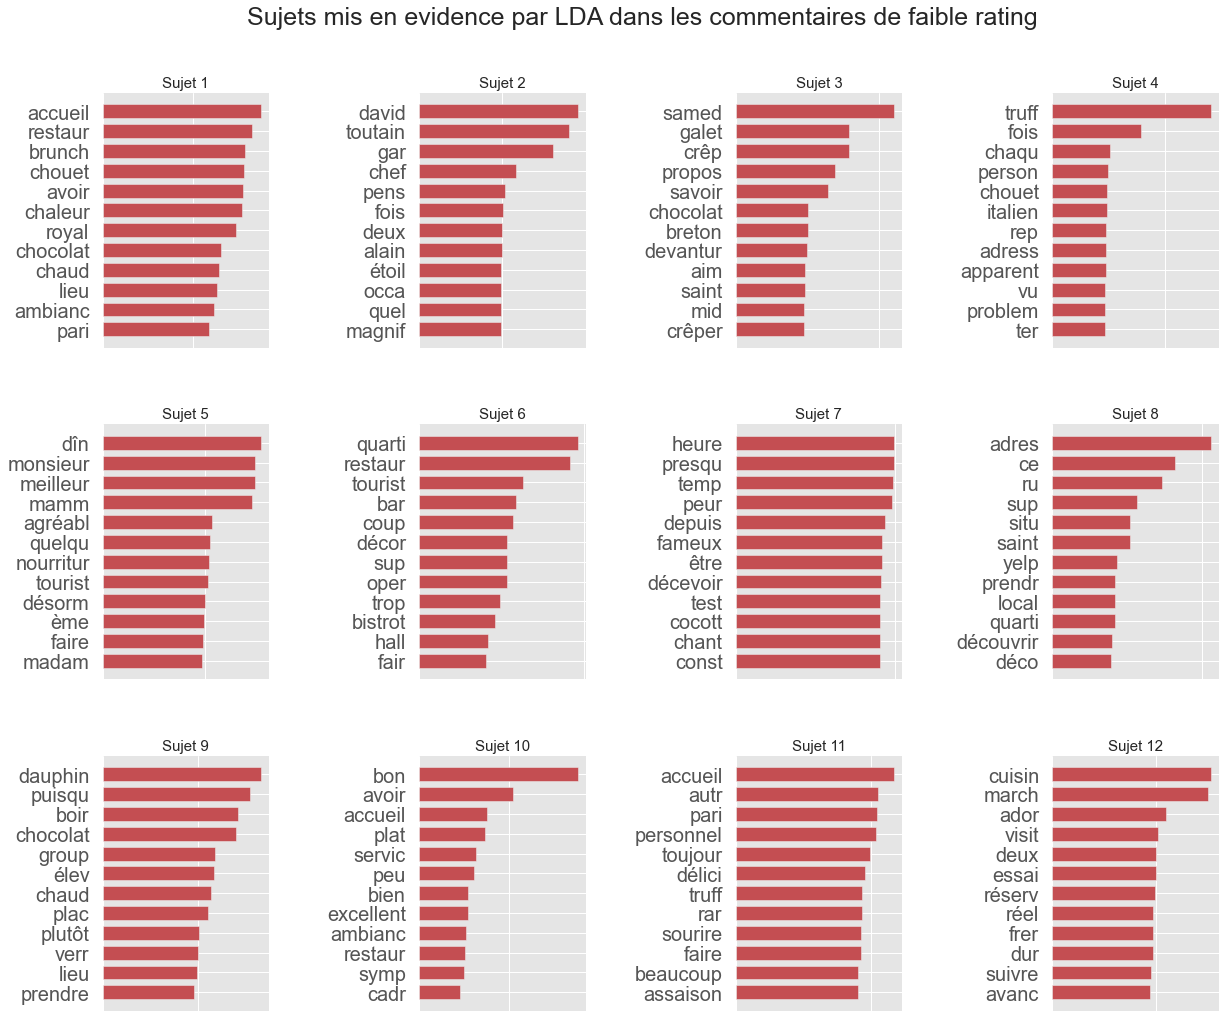

In [64]:
data_all_nmf = {'features_all_nmf': [], 'weights_all_nmf': []}

In [ ]:
def plot_top_words_nmf(model, feature_names, n_top_words,
                       title, color):
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:n_top_words]):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        for i in top_features_ind:
            data_all_nmf['features_all_nmf'].append(feature_names[i])
            data_all_nmf['weights_all_nmf'].append(topic[i])

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,
                color=color)
        ax.set_title(f'Sujet {topic_idx + 1}',
                     fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)
        ax.tick_params(bottom=False)
        ax.set(xticklabels=[])

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [65]:
no_top_words = 12
plot_top_words_nmf(nmf, tfidf_feature_names, no_top_words,
                   'Sujets mis en evidence par NMF', 'g')

In [ ]:
data_text_all_nmf = pd.DataFrame(data_all_nmf)
data_text_all_nmf.to_csv("data/P6_02_text_all_NMF.csv", sep=',', index=False)



<a id='data_low_com2'>
### I.4.5) Cas des commentaires avec faible rating :

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=2)
tfidf = tfidf_vectorizer.fit_transform(reviews_clean_neg)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1,
          l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)


In [67]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)


<font color = "grey"><i>istribution des mots sur chaque sujet :
</i></font>


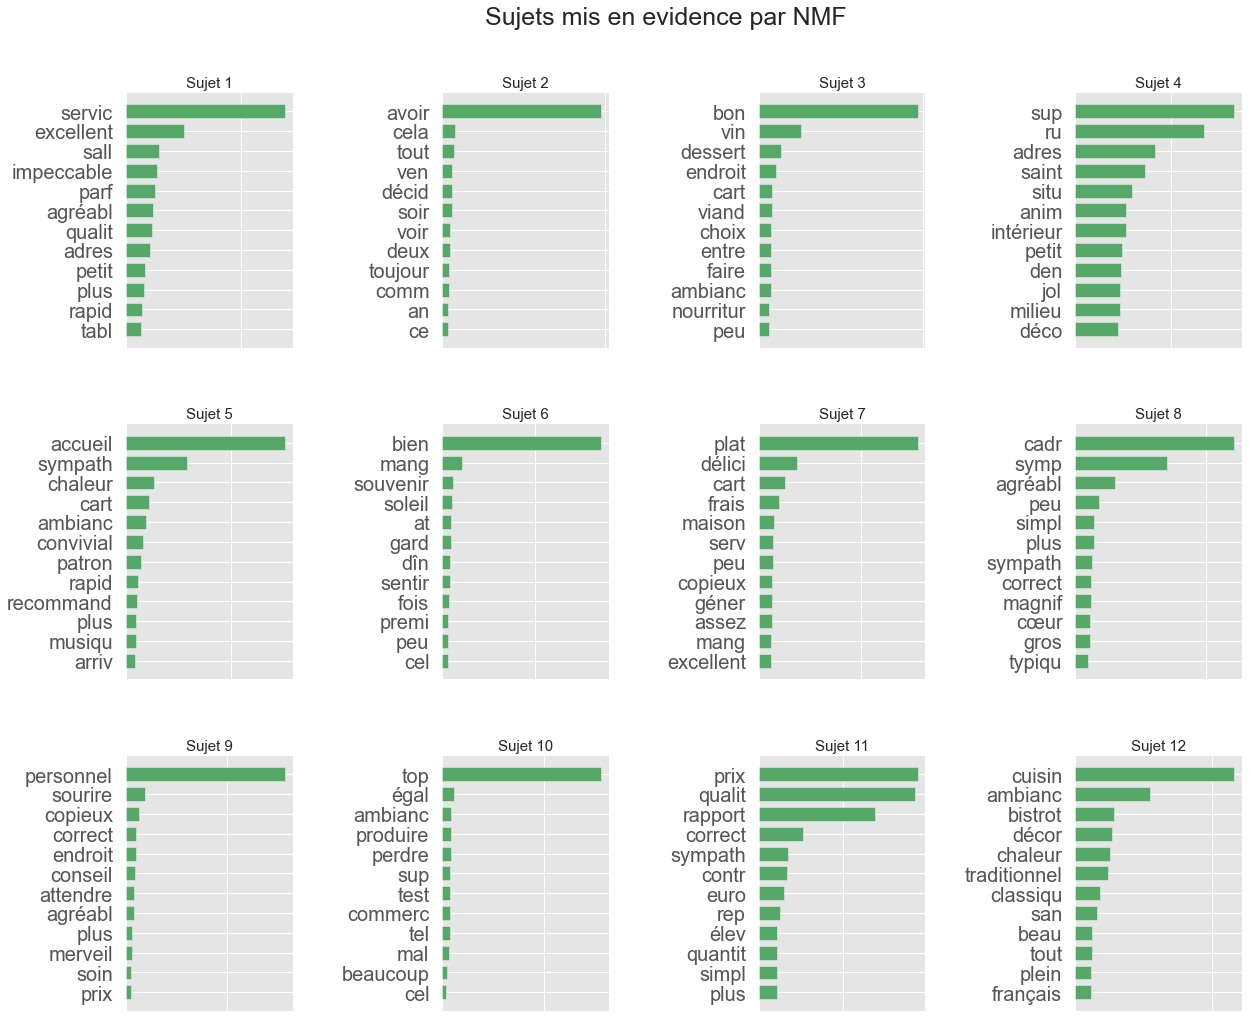

In [69]:
data_neg_nmf = {'features_neg_nmf': [], 'weights_neg_nmf': []}


In [70]:
def plot_top_words_neg_nmf(model, feature_names, n_top_words,
                           title, color):
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:n_top_words]):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        for i in top_features_ind:
            data_neg_nmf['features_neg_nmf'].append(feature_names[i])
            data_neg_nmf['weights_neg_nmf'].append(topic[i])

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,
                color=color)
        ax.set_title(f'Sujet {topic_idx + 1}',
                     fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)
        ax.tick_params(bottom=False)
        ax.set(xticklabels=[])

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
no_top_words = 12
plot_top_words_neg_nmf(nmf, tfidf_feature_names, no_top_words,
                       'Sujets mis en evidence par NMF pour les faibles ratings',
                       'r')


In [71]:
data_text_neg_nmf = pd.DataFrame(data_neg_nmf)
data_text_neg_nmf.to_csv("data/P6_02_text_neg_NMF.csv", sep=',', index=False)


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning:

`alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead



NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=20, random_state=1)

<a id='data_evi'>

### I.4.6 )Mise en évidence des mots utilisés dans les commentaires d'insatisfaction :
<font color = "grey"><i>Utilisation de la régression logisitque.
</i></font>


In [ ]:
cv = CountVectorizer(binary=False)
cv.fit(reviews_clean)
X = cv.transform(reviews_clean)


<font color = "green"><i> affectation à la classe  **1** à un commentaire positif dont le rating est **>= 3** sinon **0** pour un commentaire négatif

</i></font>

In [74]:
target = [1 if rate >= 3 else 0 for rate in rating]


<font color = "grey"><i> Entrainement du modèle :
</i></font>


In [76]:
X_train, X_val, y_train, y_val = train_test_split(X, target,
                                                  train_size=0.75)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c, max_iter=800)
    lr.fit(X_train, y_train)
    print("Accuracy for C=%s: %s"
          % (c, accuracy_score(y_val, lr.predict(X_val))))


<font color = "grey"><i>Récupération de mots et de leur importance dans ce modèle :
</i></font>


In [77]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), lr.coef_[0]
    )
}
feature_to_coef


<font color = "grey"><i>Commentaires avec un rating >= 3 :
</i></font>

In [78]:
for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(best_positive)

* Pour les commentaires avec un rating < 3 :

In [79]:
for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1])[:10]:
    print(best_negative)

Accuracy for C=0.01: 0.8888888888888888
Accuracy for C=0.05: 0.8888888888888888
Accuracy for C=0.25: 0.8888888888888888
Accuracy for C=0.5: 0.8888888888888888
Accuracy for C=1: 0.8888888888888888


><font color = "green"><i>Pour les commentaires avec un mauvais rating, les mots les plus utilisés sont **décevoir, ramen, désagréable, prix, soupe** qui caractérisent souvent des plats que les clients n'ont pas aimé, ainsi que le prix qui revient souvent.</font>

</i></font>

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



{'abim': 0.0,
 'abord': 0.28480831741437973,
 'abrit': 0.03701665756940161,
 'absinth': 0.0,
 'absolu': 0.07128626950398266,
 'absolut': 0.03630698099923272,
 'acce': 0.0,
 'acced': 0.0,
 'accent': 0.04578157947576316,
 'accept': 0.010142362563506297,
 'acceuil': 0.003006768448258381,
 'acceuill': 0.02572170050359009,
 'accompagn': -0.1238588578088681,
 'accord': 0.034835102720349426,
 'accro': 0.03663999998373026,
 'accueil': 0.3370695245264827,
 'addit': 0.0,
 'addres': 0.011823061036877618,
 'adopt': 0.025238528228193606,
 'ador': 0.36928534811072067,
 'adoron': 0.0,
 'adres': 0.3962295418766787,
 'adress': 0.16464874762335538,
 'affair': 0.03978150758616474,
 'affection': 0.039982107999038854,
 'affich': 0.08923173773249236,
 'affreux': 0.039746592050084406,
 'afghan': 0.059253213260106845,
 'afin': 0.05740462565469027,
 'afraid': 0.0,
 'afront': 0.06306391651725243,
 'agir': 0.10756387009884104,
 'agneau': 0.04386228448759283,
 'agrand': 0.10430534843263387,
 'agréabl': 0.57220109

<a id='#data_pic'></a>
# III) Analyse des photos des restaurants

<a id='#data_pre_proc_visu'></a>
## III.1) Pré-traitement des données visuelles

> L'histogramme des images va être représenté et des corrections d'image telles que **l'étirement pour l'exposition ou l'égalisation pour le contraste** vont être appliquées.
> L'algorithme de **SIFT (Scale Invariant Feature Transform)** permet de détecter efficacement les features d'une image.
> Les réseaux de neuronnes **CNN (Convutionnal Neural Network)** permettent de classifier les photos.

* Chargement des images :

In [81]:
from PIL import Image, ImageOps
import requests
from io import BytesIO

photos = []


def load_img(df):
    for i in df_yelp.index:
        photos.append(df["photo_1"][i].strip())
        photos.append(df["photo_2"][i].strip())
        photos.append(df["photo_3"][i].strip())


load_img(df_yelp)

('peu', 0.625979716294116)
('agréabl', 0.5722010993712411)
('cart', 0.5542301014027019)
('délici', 0.5408072628579237)
('sup', 0.5092829909576262)
('avoir', 0.47205283004602056)
('mang', 0.4422028924344884)
('petit', 0.44069197682677463)
('bon', 0.4260203024096338)
('top', 0.42376735352632544)


<font color = "grey"><i>Histogrammes des images originales
</i></font>


In [82]:
def display_histo(photos, nb_photos):
    i = 0
    for elt in photos[:nb_photos]:
        i += 1
        response = requests.get(elt)
        img = Image.open(BytesIO(response.content))
        mat = np.array(img)
        w, h = img.size
        print("Largeur : {} px, hauteur : {} px"
              .format(w, h))
        print("Taille de la matrice de pixels : {}"
              .format(mat.shape))
        n, bins, patches = plt.hist(mat.flatten(),
                                    bins=range(256))
        plt.title("Histogramme de l'image {}".format(i),
                  fontsize=18)
        img.show()
        plt.show()


('not', -0.9854226665208287)
('contr', -0.9168269991995583)
('prix', -0.8679009764009267)
('desagr', -0.747762367564024)
('dmg', -0.747762367564024)
('giraf', -0.7045579345876393)
('monsieur', -0.6433907003160338)
('brasser', -0.6330098672141152)
('commentair', -0.614513129456917)
('bel', -0.5992430040291882)


In [ ]:
display_histo(photos, 4)



> <font color = "green"><i>Les images présentent des différences de luminosité entre certaines zone notamment avec la présence de pic pour certaines zones, il faut donc égaliser ces images pour corriger le contraste (méthode equalize).</font>

</i></font>

<font color = "grey"><i> Lissage (ou débruitage) par l'application d'un filtre moyenneur :
</i></font>

><font color = "green"><i>Le bruit des images va être corrigé par l'application de filtres **(filtre moyenneur, médian, gaussien, non local means)**. Il existe différents bruits tels que le bruit gaussien ou le bruit impulsionnel.
Ici on utilise le filtre moyenneur de taille 3X3. De plus, les images vont être égalisées afin de corriger le contraste.


In [83]:
images = []

In [ ]:
def filter_img(img):
    img = img.filter(ImageFilter.BoxBlur(1))
    return img


In [84]:
def clean_cont(img):
    #   img = img.convert('L')
    img = ImageOps.equalize(img)
    return img


Largeur : 1000 px, hauteur : 750 px
Taille de la matrice de pixels : (750, 1000, 3)


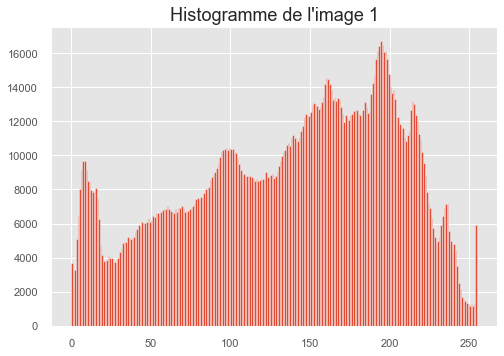

Largeur : 1000 px, hauteur : 488 px
Taille de la matrice de pixels : (488, 1000, 3)


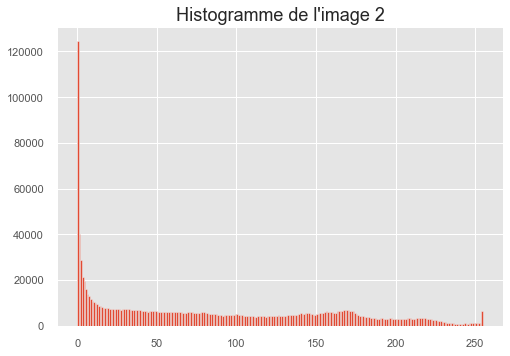

Largeur : 750 px, hauteur : 1000 px
Taille de la matrice de pixels : (1000, 750, 3)


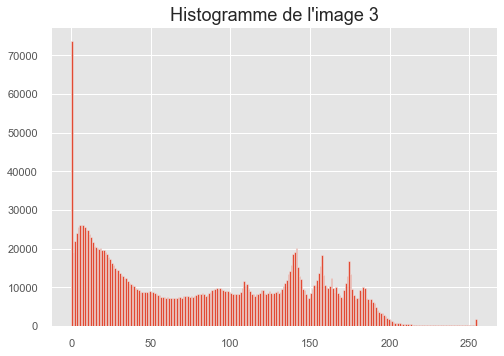

Largeur : 1000 px, hauteur : 750 px
Taille de la matrice de pixels : (750, 1000, 3)


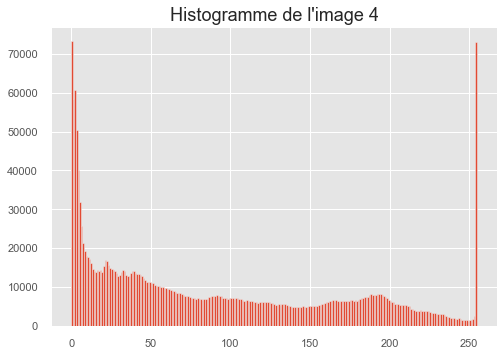

In [85]:
images = []
images_1 = []
images_2 = []

for elt in photos:
    response = requests.get(elt)
    img = Image.open(BytesIO(response.content))
    img = img.resize((150, 150))
    images_2.append(asarray(img))
    img = filter_img(img)
    img = clean_cont(img)
    img = img.resize((45, 45))
    images.append(asarray(img))
    images_1.append(asarray(img).flatten())

img = np.array(images)
img_1 = np.array(images_1)
img_2 = np.array(images_2)


In [ ]:
def display_histo_trt(image, nb_img):
    i = 0
    for elt in image[:nb_img]:
        i += 1
        n, bins, patches = plt.hist(elt.flatten(),
                                    bins=range(256))
        plt.title("Histogramme de l'image {} traitée".format(i),
                  fontsize=18)
        plt.show()


In [ ]:
display_histo_trt(images_1, 4)



><font color = "green"><i>Les pixels sont répartis plus uniformément sur tous les niveaux d'intensité de l'histogramme. La luminosité des images est plus répartie.</font>
</i></font>

<a id='data_acp_reduc'>

## III.2) Réduction de dimension et visualisation / PCA




In [92]:
std_scale = preprocessing.StandardScaler().fit(img_1)
X_scaled = std_scale.transform(img_1)

pca = decomposition.PCA(n_components=180).fit(X_scaled)
X_projected = pca.transform(X_scaled)

print(pca.explained_variance_ratio_.cumsum())

[0.10673081 0.17836455 0.22149401 0.25927227 0.29038603 0.3194467
 0.34658651 0.36714114 0.38599652 0.40225906 0.41805621 0.43350476
 0.44816466 0.46083574 0.47313355 0.4844632  0.49515958 0.50520039
 0.5148946  0.52396961 0.53224146 0.54047589 0.54797626 0.55520468
 0.56239931 0.56933083 0.5760629  0.58256383 0.58875309 0.59478695
 0.60062567 0.60630262 0.6118687  0.61732539 0.62259634 0.62774373
 0.63273093 0.63752649 0.64220179 0.64685116 0.65139195 0.6558129
 0.66016036 0.6643548  0.66845699 0.67248646 0.6763591  0.68020283
 0.68390818 0.68752504 0.69110118 0.69459348 0.69795944 0.70126668
 0.70452531 0.70775894 0.71088721 0.7139684  0.71698568 0.71993409
 0.72281674 0.72563646 0.72839555 0.73110169 0.73379133 0.73643904
 0.73904335 0.74160438 0.7441288  0.74662458 0.74910784 0.75153219
 0.75390748 0.75624415 0.75853095 0.76078798 0.76301792 0.76524254
 0.76742586 0.76959495 0.77172535 0.77381337 0.77588668 0.77790557
 0.77990846 0.78186947 0.7838163  0.78573693 0.78764301 0.789537

><font color = "green"><i></i></font>Les **16  premières composantes principales** de l' ACP expliquent plus de de 50% de la variance de notre jeu de données.


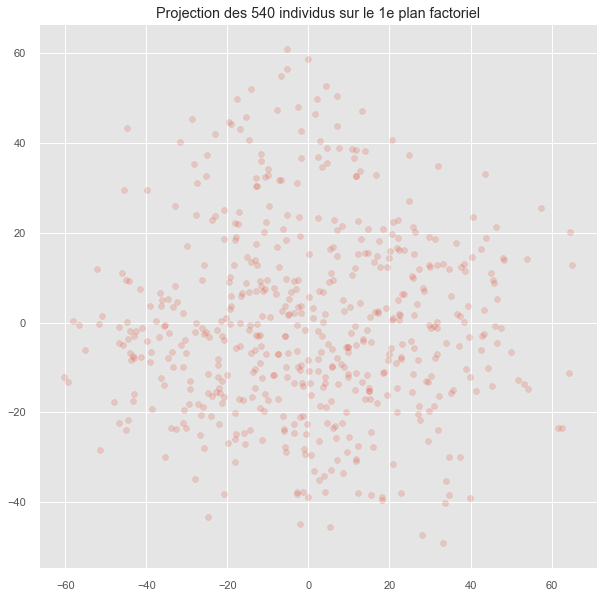

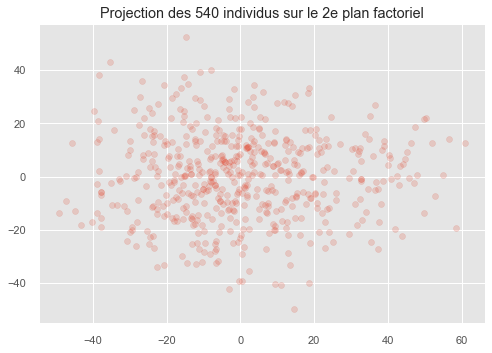

In [93]:
plt.figure(figsize=(10, 10))

for i in range(2):
    plt.scatter(X_projected[:, i], X_projected[:, i + 1],
                cmap='hsv', alpha=.2)

    plt.title("Projection des {} individus sur le {}e plan factoriel"
              .format(X_projected.shape[0], i + 1))
    plt.show()


<font color = "grey"><i>Visualisation t-SNE des images  dans le 1er plan factoriel après une réduction par ACP :
</i></font>


In [94]:

# fonction pour afficher une partie des images sur la visualisation 2D
def plot_embedding(Z, title=None):
    x_min, x_max = np.min(Z, 0), np.max(Z, 0)
    X = (Z - x_min) / (x_max - x_min)

    plt.figure(figsize=(12, 12))
    ax = plt.subplot(111)

    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 2e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            props = {'boxstyle': 'round', 'edgecolor': 'white'}
            imagebox = offsetbox.AnnotationBbox(offsetbox
                                                .OffsetImage(img[i],
                                                             cmap=plt.cm.gray,
                                                             zoom=1),
                                                X[i], bboxprops=props)
            ax.add_artist(imagebox)
    if title is not None:
        plt.suptitle(title, fontsize=18)


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



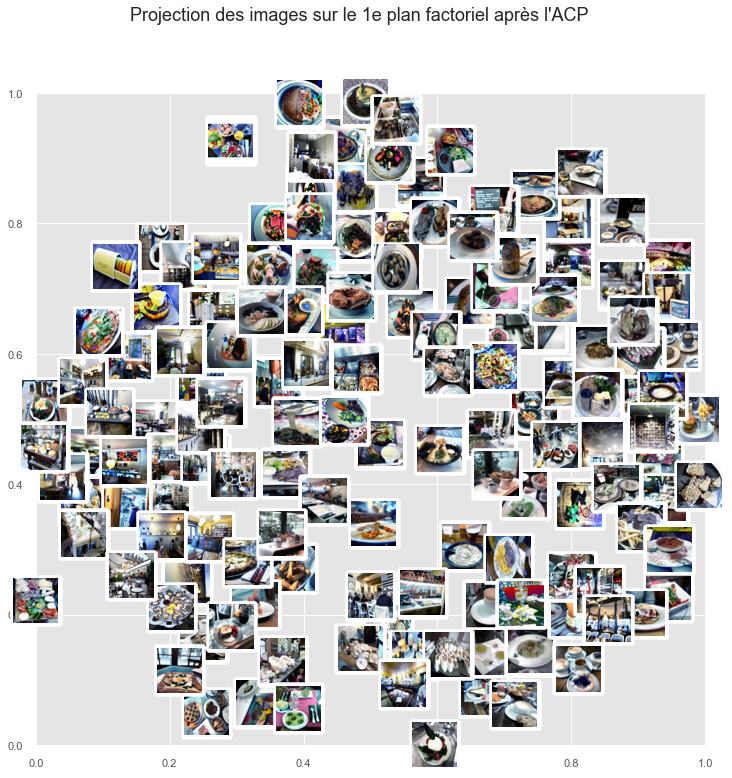

In [95]:
tsne = manifold.TSNE(n_components=2, perplexity=5, n_iter=3000, init='pca')
X_tsne = tsne.fit_transform(X_projected)
X_tsne_std = preprocessing.StandardScaler().fit_transform(X_tsne)
plot_embedding(X_tsne_std, "Projection des images sur le 1e plan factoriel après l'ACP")
plt.show()


><font color = "green"><i> La notion de localité et de similarité est mise en evidence par la méthode t-SNE. Notamment par la formation de groupes d'image ressemblantes telles que des soupes au somment de la visualisation, des desserts au centre, des images du décor intérieur des restaurants au centre gauche.</font>
</i></font>

<font color = "grey"><i>Visualisation t-SNE en 3D :
</i></font>


c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

No handles with labels found to put in legend.


(-2.5, 2.5)

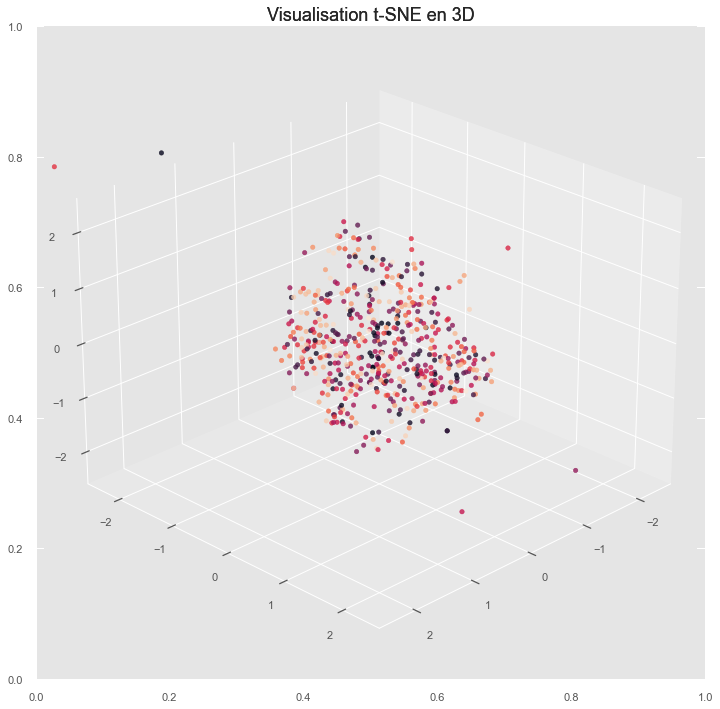

In [96]:
tsne = manifold.TSNE(n_components=3, perplexity=5,
                     n_iter=3000, init='pca')
tsne_result = tsne.fit_transform(X_projected)
tsne_result_scaled = preprocessing.StandardScaler().fit_transform(tsne_result)

fig = plt.figure(figsize=(12, 12))

plt.title("Visualisation t-SNE en 3D", fontsize=18)
ax = fig.add_subplot(111, projection='3d')

plt.grid()
N = 540
colors = np.random.rand(N)

ax.scatter(tsne_result_scaled[:, 0],
           tsne_result_scaled[:, 1],
           tsne_result_scaled[:, 2],
           alpha=0.8,
           c=colors,
           marker='o')
ax.set_title("Visualisation t-SNE en 3D", fontsize=18)
ax.legend(loc='best')
ax.view_init(25, 45)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)

In [97]:
## c) Labellisation automatique des images des restaurants à l'aide de **KMeans**

In [98]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer


def KelbowVisualizer(X, nb_clust):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, nb_clust))
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    visualizer.fit(X_scaled)
    visualizer.poof()


def elbow(X, k):
    hist = []
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    for kclusters in range(1, k):
        #n_jobs=-1 to use all your CPUs
        #n_jobs=-2 to use all of them except one
        Km = KMeans(random_state=1,
                    n_clusters=kclusters,
                    init='k-means++').fit(X_scaled)
        hist.append(Km.inertia_)

    plt.figure(figsize=(15, 8))
    plt.grid()
    plt.plot(range(1, k), hist, 'o-')
    plt.ylabel('Somme des distances quadratiques au centroide',
               fontsize=14)
    plt.xlabel('Nombre de clusters', fontsize=14)
    plt.title('Méthode du coude', fontsize=18)
    plt.show()


* Utilisation du **KelbowVisualizer** :

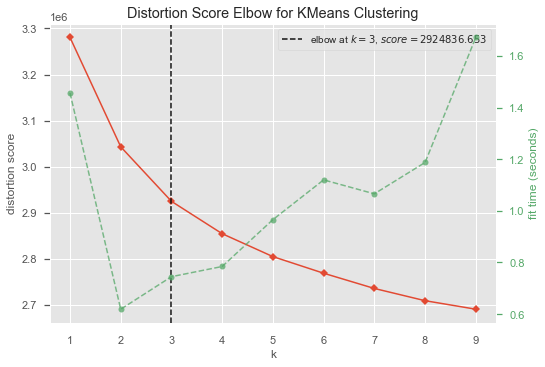

In [99]:
KelbowVisualizer(img_1, 10)

* Affichage du coefficient de silhouette pour la mesure de la performance en fonction des 3 clusters :

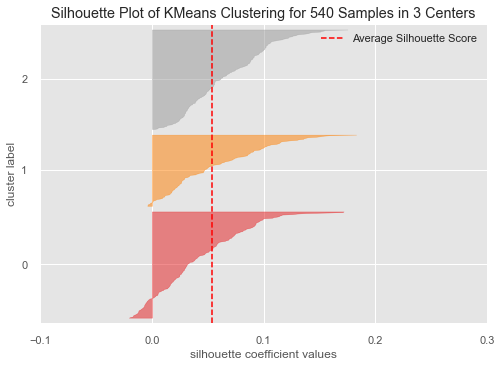

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 540 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [100]:
model = KMeans(n_clusters=3, init='random', n_init=10)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_scaled)
visualizer.poof()

* Utilisation de la méthode **elbow** :

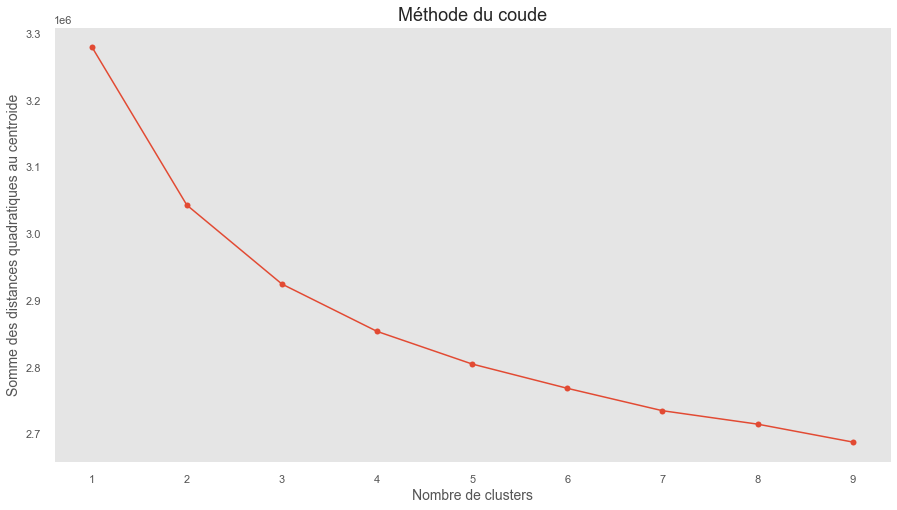

In [101]:
elbow(img_1, 10)

> <font color='red'>ANALYSE</font>

> <font color='red'>Le choix de **k=3** est justifié par un **coude** de la courbe du score de distortion.</font>

* Réduction de dimensions ACP et visualisation des données sur les 10 premiers plans factoriels :

In [102]:
std_scale = preprocessing.StandardScaler().fit(img_1)
X_scaled = std_scale.transform(img_1)

pca = decomposition.PCA(n_components=180).fit(X_scaled)
X_projected = pca.transform(X_scaled)

print(pca.explained_variance_ratio_.cumsum())

[0.10673081 0.17836455 0.22149401 0.25927227 0.29038603 0.3194467
 0.34658651 0.36714114 0.38599652 0.40225906 0.41805621 0.43350476
 0.44816466 0.46083574 0.47313355 0.4844632  0.49515958 0.50520039
 0.5148946  0.52396961 0.53224146 0.54047589 0.54797626 0.55520468
 0.56239931 0.56933083 0.5760629  0.58256383 0.58875309 0.59478695
 0.60062567 0.60630262 0.6118687  0.61732539 0.62259634 0.62774373
 0.63273093 0.63752649 0.64220179 0.64685116 0.65139195 0.6558129
 0.66016036 0.6643548  0.66845699 0.67248646 0.6763591  0.68020283
 0.68390818 0.68752504 0.69110118 0.69459348 0.69795945 0.70126669
 0.70452531 0.70775894 0.71088722 0.7139684  0.71698568 0.71993409
 0.72281674 0.72563646 0.72839555 0.73110168 0.73379133 0.73643903
 0.73904333 0.74160435 0.74412878 0.74662457 0.74910784 0.75153214
 0.75390741 0.75624408 0.75853089 0.76078793 0.76301784 0.76524236
 0.76742569 0.76959474 0.77172509 0.77381313 0.77588649 0.77790535
 0.77990815 0.78186908 0.78381568 0.78573637 0.78764251 0.789536

> Les **19 premières composantes principales** de l' ACP expliquent plus de de 50% de la variance de notre jeu de données.

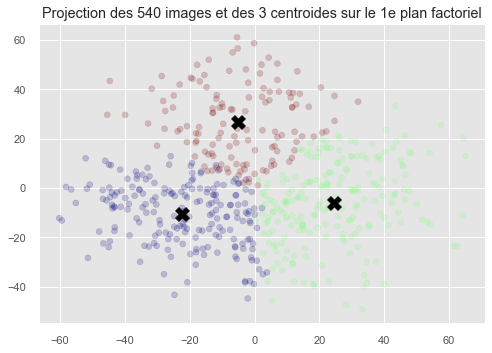

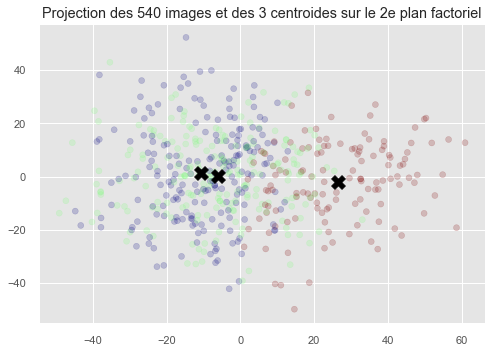

In [103]:
model.fit(X_scaled)

plt.figure()
clusters = model.labels_
label_to_id_dict = {v: i for i, v in enumerate(np.unique(clusters))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

centroids = model.cluster_centers_
centroids_projected = pca.transform(centroids)

for i in range(2):
    plt.scatter(X_projected[:, i], X_projected[:, i + 1],
                c=clusters.astype(np.float),
                cmap='jet', alpha=.2,
                label=clusters)
    plt.scatter(centroids_projected[:, i],
                centroids_projected[:, i + 1],
                marker='X',
                color='black',
                alpha=1,
                s=200)

    plt.title(
        "Projection des {} images et des 3 centroides sur le {}e plan factoriel".format(X_projected.shape[0], i + 1))
    plt.show()


In [104]:
data_img_clus_2D = pd.DataFrame(X_projected)
data_img_clus_2D['cluster'] = clusters
data_img_clus_2D.to_csv("data/P6_02_img_clus_2D.csv", sep=',', index=False)

In [105]:
data_img_centr_2D = pd.DataFrame(centroids_projected)
data_img_centr_2D.to_csv("data/P6_02_img_centr_2D.csv", sep=',', index=False)

* Visualisation en 3D des clusters avec les centroides :

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



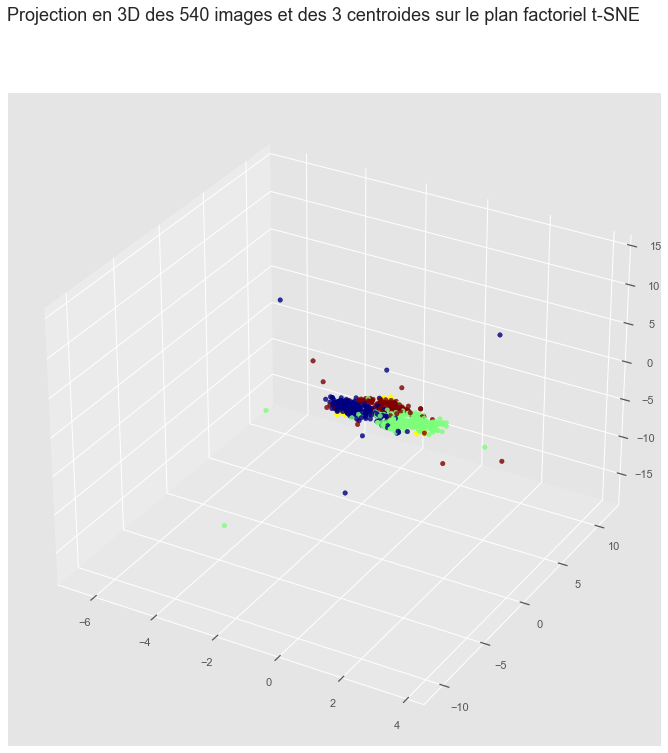

No handles with labels found to put in legend.


(-2.5, 2.5)

In [106]:
tsne = manifold.TSNE(n_components=3, perplexity=5,
                     n_iter=3000, init='pca')

tsne_result = tsne.fit_transform(X_projected)
tsne_result_scaled = preprocessing.StandardScaler().fit_transform(tsne_result)

tsne_res_center = tsne.fit_transform(centroids_projected)
tsne_res_scaled = preprocessing.StandardScaler().fit_transform(tsne_res_center)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

plt.grid()

ax.scatter(tsne_result_scaled[:, 0],
           tsne_result_scaled[:, 1],
           tsne_result_scaled[:, 2],
           c=clusters.astype(np.float),
           cmap='jet', alpha=.8)
ax.scatter(tsne_res_scaled[:, 0],
           tsne_res_scaled[:, 1],
           tsne_res_scaled[:, 2],
           marker='X',
           color='yellow',
           alpha=1,
           s=200)

plt.suptitle("Projection en 3D des {} images et des 3 centroides sur le plan factoriel t-SNE"
             .format(tsne_result_scaled.shape[0]),
             fontsize=18)
plt.show()

ax.legend(loc='best')
ax.view_init(20, 40)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)


In [107]:
data_img_clus_3D = pd.DataFrame(tsne_result_scaled)
data_img_clus_3D['cluster'] = clusters
data_img_clus_3D.to_csv("data/P6_02_img_clus_3D.csv", sep=',', index=False)

> <font color='red'>ANALYSE</font>

> <font color='red'>Les données images et les centroides des clusters sont concentrés.</font>

* Définition et inteprêtation des 3 clusters :

In [108]:
cluster_0 = []
cluster_1 = []
cluster_2 = []

for i in data_img_clus_2D.index:
    if data_img_clus_2D["cluster"][i] == 0:
        cluster_0.append(i)

for i in data_img_clus_2D.index:
    if data_img_clus_2D["cluster"][i] == 1:
        cluster_1.append(i)

for i in data_img_clus_2D.index:
    if data_img_clus_2D["cluster"][i] == 2:
        cluster_2.append(i)

In [109]:
def plot_clust(cluster, title):
    fig, axes = plt.subplots(3, 4, figsize=(12, 10))
    axes = axes.flatten()
    for idx, elt in enumerate(cluster[:12]):
        ax = axes[idx]
        image = img_2[elt]
        height, width, l = image.shape
        ax.axis('off')
        ax.set_title("%dx%d" % (width, height))
        ax.imshow(image)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.suptitle(title, fontsize=18)
    plt.show()


* **Images du cluster 1 :**

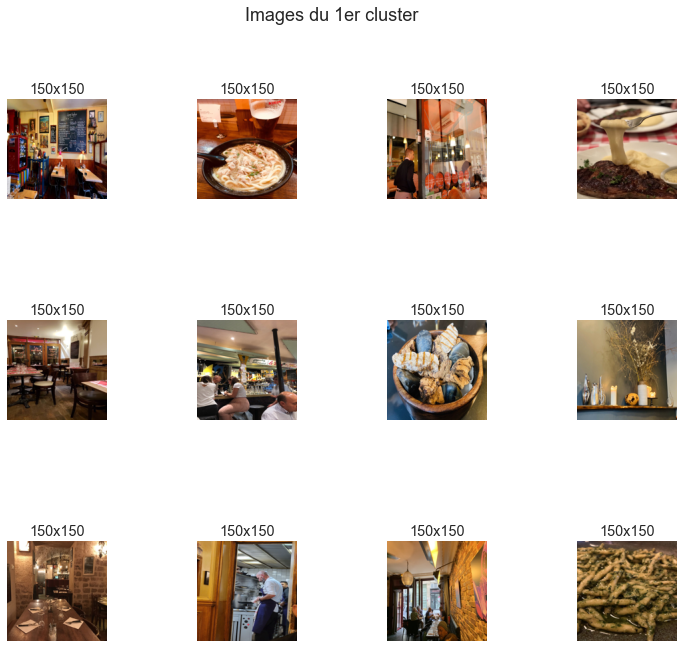

In [110]:
plot_clust(cluster_0, "Images du 1er cluster")

* **Images du cluster 2:**

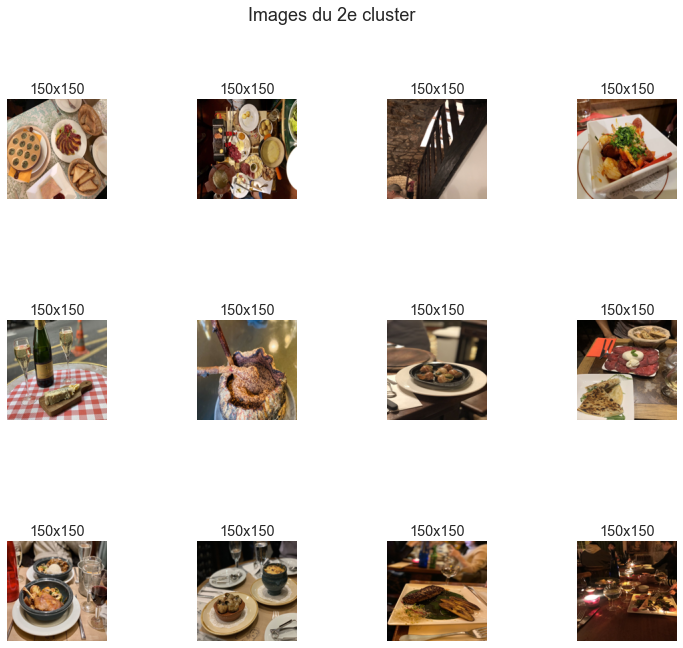

In [111]:
plot_clust(cluster_1, "Images du 2e cluster")

* **Images du cluster 3:**

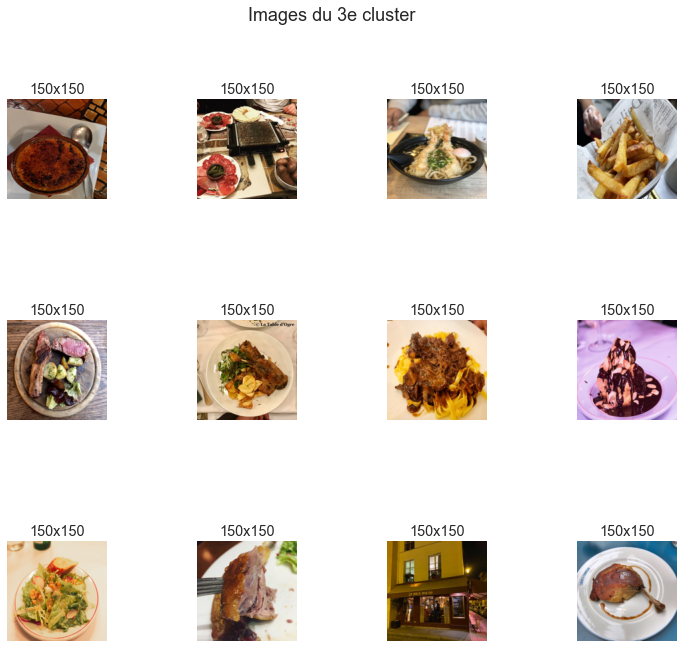

In [112]:
plot_clust(cluster_2, "Images du 3e cluster")

> <font color='red'>ANALYSE</font>

> <font color='red'> Chaque cluster regroupe des images avec des caractéristiques prédominante. Le cluster 1 regroupe en majorité des images du décor intérieur, Le cluster 2 regroupe en majorité des images d’aliments de forme circulaire et des assiettes qui présentent la même forme, Le cluster 3 regroupe en majorité des images contenant des objets en grand nombre (bouteilles, assiettes).</font>

## d) Labellisation des images par **CNN (Convolutional Neural Network)**

In [113]:
model = VGG16()

In [114]:
def vgg16_predict(mdl, image, nb_img):
    for elt in image[:nb_img]:
        print(elt)
        response = requests.get(elt)
        img = Image.open(BytesIO(response.content))
        img_cnn = img.resize((224, 224))
        print("taille", img_cnn.size)
        img_cnn.save('data/new_img.jpg')

        #img_size = load_img('data/new_img.jpg')

        img_cnn = img_to_array(img_cnn)
        img_cnn = img_cnn.reshape((1, img_cnn.shape[0],
                                   img_cnn.shape[1],
                                   img_cnn.shape[2]))
        img_cnn = preprocess_input(img_cnn)
        y = mdl.predict(img_cnn)
        print('Top  :', decode_predictions(y, top=1)[0])


vgg16_predict(model, photos, 9)

https://s3-media4.fl.yelpcdn.com/bphoto/GZomUiX8isxQYR-xEtzAfw/o.jpg
taille (224, 224)
Top  : [('n02776631', 'bakery', 0.26764238)]
https://s3-media2.fl.yelpcdn.com/bphoto/V8MbTzJ5KT2vgdBJGnNbOQ/o.jpg
taille (224, 224)
Top  : [('n03661043', 'library', 0.22910255)]
https://s3-media2.fl.yelpcdn.com/bphoto/pw9BO8ksJPgFZBEvfWgCBA/o.jpg
taille (224, 224)
Top  : [('n07871810', 'meat_loaf', 0.16030659)]
https://s3-media2.fl.yelpcdn.com/bphoto/qh-rZGj0r8FbtHt9_6sP_Q/o.jpg
taille (224, 224)
Top  : [('n04447861', 'toilet_seat', 0.21598566)]
https://s3-media1.fl.yelpcdn.com/bphoto/6dZMDZNJ6VargXZQXr49iA/o.jpg
taille (224, 224)
Top  : [('n03467068', 'guillotine', 0.1171202)]
https://s3-media3.fl.yelpcdn.com/bphoto/hUE6J43KQSu9F2xM2NnGNQ/o.jpg
taille (224, 224)
Top  : [('n02776631', 'bakery', 0.2187736)]
https://s3-media1.fl.yelpcdn.com/bphoto/1NCC7PiIP0sMuUpYIkRvKw/o.jpg
taille (224, 224)
Top  : [('n07590611', 'hot_pot', 0.28110045)]
https://s3-media4.fl.yelpcdn.com/bphoto/x0aPCzAiZq-mJPy4f9gj5Q/o

* Transfert learning :

In [115]:

model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

> Extraction de features. On n'entraine pas les poids sur toutes les couches donc on conserve ces poids obtenus par le modèle **VGG16** sur la base **ImageNet**.

In [116]:
for layers in (model.layers):
    print(layers)
    layers.trainable = False

> Création d'une couche dense pour détecter les 3 classes **(nourriture et décor intérieur, plats ou vaisselle, restaurant extérieur)**

In [117]:


X = model.layers[-2].output
predictions = Dense(3, activation="softmax")(X)
model_final = Model(inputs=model.input, outputs=predictions)

model_final.compile(loss="categorical_crossentropy",
                    optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
                    metrics=["accuracy"])

model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

c:\users\marj1\pycharmprojects\projet6\env\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [118]:
cluster_cnn_0 = []
cluster_cnn_1 = []
cluster_cnn_2 = []


def vgg16_predict_new(mdl, image, nb_img):
    i = 0
    for elt in image[:nb_img]:
        response = requests.get(elt)
        img = Image.open(BytesIO(response.content))
        img_cnn = img.resize((224, 224))
        img_cnn.save('data/new_img.jpg')
        #img_cnn = load_img('data/new_img.jpg')

        img_cnn = img_to_array(img_cnn)
        img_cnn = img_cnn.reshape((1, img_cnn.shape[0],
                                   img_cnn.shape[1],
                                   img_cnn.shape[2]))
        img_cnn = preprocess_input(img_cnn)
        y = mdl.predict(img_cnn)
        if (y[0][0] > y[0][1] and y[0][0] > y[0][2]):
            cluster_cnn_0.append(i)
        if (y[0][1] > y[0][0] and y[0][1] > y[0][2]):
            cluster_cnn_1.append(i)
        if (y[0][2] > y[0][0] and y[0][2] > y[0][1]):
            cluster_cnn_2.append(i)
        i += 1


vgg16_predict_new(model_final, photos, 200)

* **Images de la classe 1:**

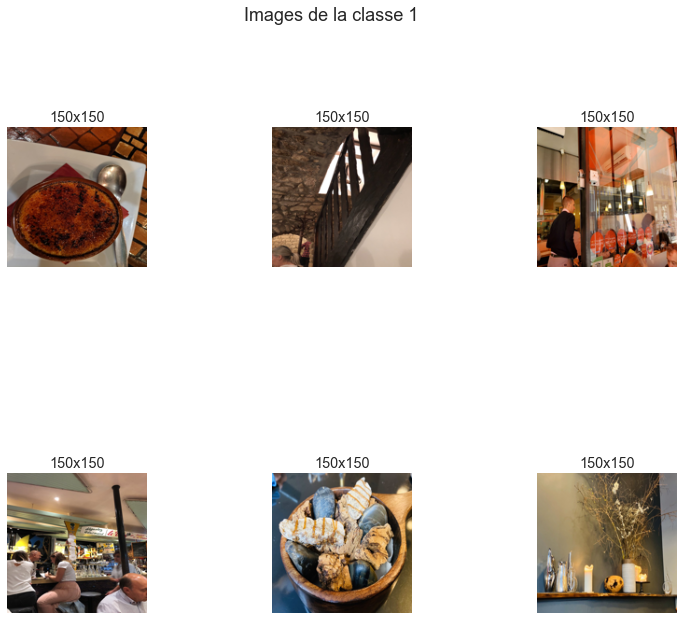

In [119]:
def plot_clust_cnn(cluster, title):
    fig, axes = plt.subplots(2, 3, figsize=(12, 10))
    axes = axes.flatten()
    for idx, elt in enumerate(cluster[:6]):
        ax = axes[idx]
        image = photos[elt]
        response = requests.get(image)
        img = Image.open(BytesIO(response.content))
        img_cnn = img.resize((150, 150))
        img_cnn.save('data/new_img.jpg')
        #img_cnn = load_img('data/new_img.jpg')
        img_cnn = np.asarray(img_cnn)
        height, width, l = img_cnn.shape
        ax.axis('off')
        ax.set_title("%dx%d" % (width, height))
        ax.imshow(img_cnn)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.suptitle(title, fontsize=18)
    plt.show()


plot_clust_cnn(cluster_cnn_0, "Images de la classe 1")

* Images de la classe 2:

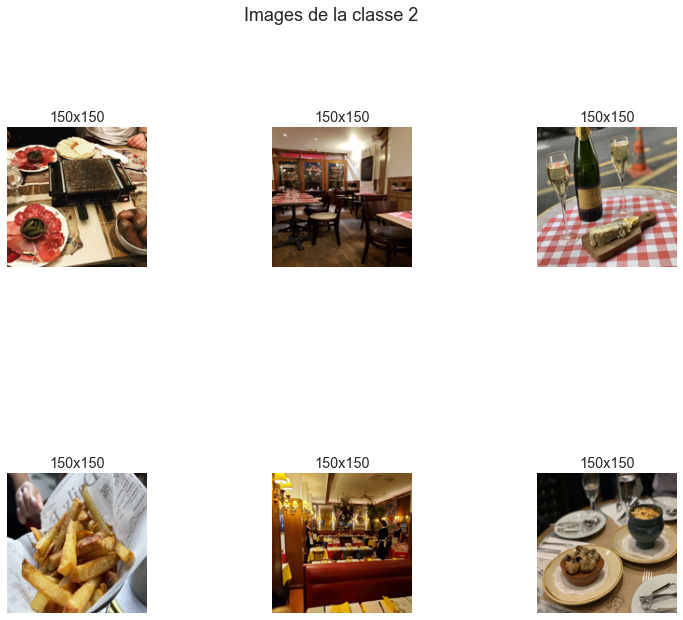

In [120]:
plot_clust_cnn(cluster_cnn_1, "Images de la classe 2")

* Images de la classe 3:

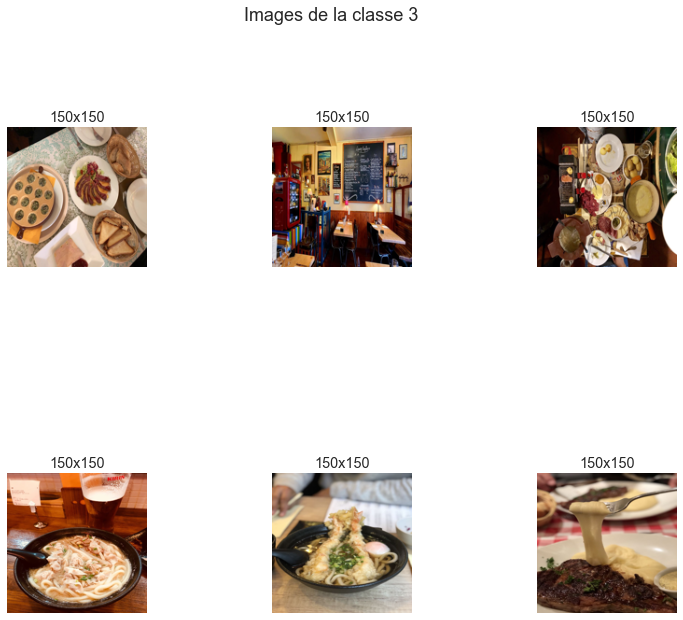

In [121]:
plot_clust_cnn(cluster_cnn_2, "Images de la classe 3")

> <font color='red'>ANALYSE</font>

> <font color='red'>L' architecture **Vgg16** prend en entrée une image 224x224 et la classe dans une des 1000 classes. Ce modèle de CNN est pré-entrainé sur la base d'images **ImageNet**. On a supprimé la couche dense de 1000 classes afin de créer une autre couche dense à 3 classes. On observe les 3 catégories **décor intérieur, plats proposés par les restaurants, plats ou aliments circulaires**)</font>